<a href="https://colab.research.google.com/github/HyeonhoonLee/SNUCM_AI/blob/main/2020_07_24_mimic_iv_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIMIC-IV

MIMIC-IV is an update to the [MIMIC-III database](https://mimic.physionet.org/). You can read more about MIMIC-IV on the [MIMIC-IV website](https://mimic-iv.mit.edu/).

For the purposes of this tutorial, we have made a `mimic_demo` dataset on Google BigQuery accessible. We will turn off general access to this demo dataset at the end of the conference (but don't worry! It won't be gone forever.).

To use this notebook, you'll need to have a Google account with a billable project associated with it. If you've never done this before, you can get free credit from Google for the first account that you create. Querying is extremely cheap, so don't worry about using up your budget.

**YOU MUST UPDATE YOUR PROJECT_ID BELOW!** Once you've created a project, change the `project_id` variable to be equal to the project name (usually all letters with hyphens).

In [ ]:
# Set to your project ID at google
project_id = 'lcp-internal' # <-- YOU MUST CHANGE THIS

## Load libraries and connect to the database

In [ ]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Make pandas dataframes prettier
from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

dataset = 'mimic_demo'

The below link authenticates the colab notebook with Google. If you trust me (and Google), this will give this notebook the ability to query data from the BigQuery dataset on your behalf. It's a necessary step to access the data.

In [ ]:
# authenticate
auth.authenticate_user()

In [ ]:
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

We're going to go through the data in MIMIC-IV with an example patient. We'll select data for this patient using only their `subject_id`. After you've run through the notebook, you are welcome to change the `subject_id` to see the data for a different patient. This can be a useful exercise as not all patients have data recorded in every table! If this is your first time going through this notebook however, we recommend you keep the `subject_id` as is so the associated text blocks make sense.

In [ ]:
subject_id = 10012853

# Patients table

In [ ]:
query = f"""
SELECT *
FROM `physionet-data.{dataset}_core.patients`
WHERE subject_id = {subject_id}
"""
pt = run_query(query)
pt['anchor_year'] = pt['anchor_year']
pt

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10012853,F,91,2175,2014 - 2016,NaT



Here we have information for an individual person. We have their genotypical sex in the `gender` column, which is 'F' for female. Their `anchor_age` is 91, and the corresponding `anchor_year` for this age is 2175. This `anchor_year` occurred sometime between 2014 - 2016. This is our temporal anchoring of the deidentified patient stay. We know that a measurement in the database which is recorded at the deidentified date of 2175-01-01 actually occurred sometime between 2014 and 2016.

This patient's particular age brings up an important deidentification step. HIPAA requires all ages over 89 to be obscured in order to protect patient identity, and leaves the method of obfuscation up to the individual data guards. In MIMIC-IV, we have decided to set all ages over 89 to the value of 91, which is pretty close to the median age for that group. If you see a patient with an `anchor_age` of 91, then the only thing you know is that they were over 89 in the `anchor_year`. For this patient, we know they were older than 89 sometime between 2014 - 2016, which corresponds to 2175 in their deidentified time series. We've chosen 91 as it is a reasonable imputation for this age group. You can see the impact of this decision in a histogram of all ages.

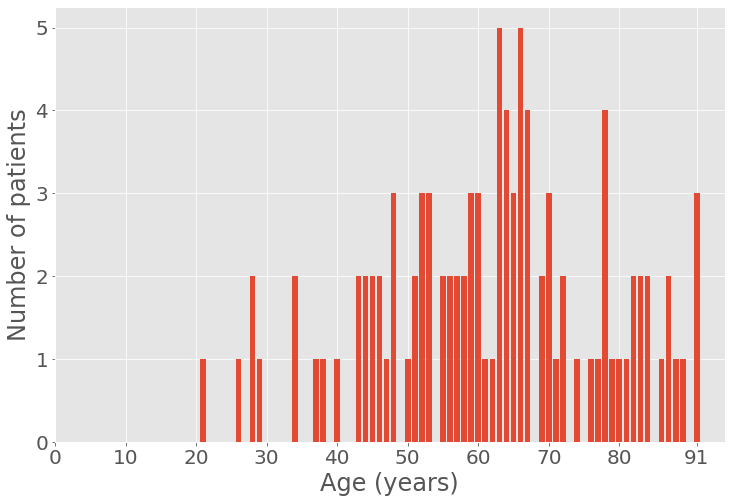

In [ ]:
# Load admissions
query = f"""
SELECT anchor_age, count(*) as n
FROM `physionet-data.{dataset}_core.patients` pt
group by anchor_age
"""
age = run_query(query)
plt.figure(figsize=[12, 8])
plt.bar(age['anchor_age'], age['n'])
plt.xticks([x for x in range(0, 90, 10)] + [91])
plt.ylabel('Number of patients')
plt.xlabel('Age (years)')
plt.show()

Now you understand why there is such a huge jump in the number of 88 year olds compared to the number of 91 year olds!

N.B. If using the demo data, this jump isn't *that* obvious - but it is in the full dataset.

## Admissions

Next up, we can look at the hospitalizations for this patient.

In [ ]:
query = f"""
SELECT *
FROM `physionet-data.{dataset}_core.admissions`
WHERE subject_id = {subject_id}
ORDER BY admittime
"""
adm = run_query(query)
adm

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag
0,10012853,26369609,2175-04-05 15:36:00,2175-04-10 16:55:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Other,ENGLISH,WIDOWED,BLACK/AFRICAN AMERICAN,2175-04-05 06:22:00,2175-04-05 17:10:00,0
1,10012853,22539296,2176-06-06 18:09:00,2176-06-08 18:30:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Medicare,ENGLISH,WIDOWED,BLACK/AFRICAN AMERICAN,2176-06-06 13:33:00,2176-06-06 20:18:00,0
2,10012853,22896692,2176-08-11 15:17:00,2176-08-11 17:35:00,NaT,EU OBSERVATION,EMERGENCY ROOM,None,Medicare,ENGLISH,WIDOWED,BLACK/AFRICAN AMERICAN,2176-08-11 08:36:00,2176-08-11 17:35:00,0
3,10012853,27882036,2176-11-25 21:28:00,2176-12-03 15:24:00,NaT,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,WIDOWED,BLACK/AFRICAN AMERICAN,2176-11-25 18:34:00,2176-11-25 23:51:00,0
4,10012853,26739864,2177-02-11 07:15:00,2177-02-12 16:20:00,NaT,DIRECT OBSERVATION,PHYSICIAN REFERRAL,None,Medicare,ENGLISH,WIDOWED,BLACK/AFRICAN AMERICAN,NaT,NaT,0
5,10012853,20457729,2177-11-03 09:30:00,2177-11-04 15:06:00,NaT,DIRECT OBSERVATION,PHYSICIAN REFERRAL,None,Medicare,ENGLISH,WIDOWED,BLACK/AFRICAN AMERICAN,NaT,NaT,0


Here we see this patient has 6 admissions over a period of 4 years. Their initial admission occurs at their earliest `admittime`: 2175-04-05 15:36:00. Recall from the *patients* table that 2175 was their `anchor_year`; therefore we know that this admission occurred sometime between 2014 - 2016. Their final admission is in 2177, and by extension we know this admission must have occurred sometime between 2016 - 2018.

Going back to the first admission, we can see it lasted for about 5 days, and the patient was admitted to the hospital via the emergency room. We can get a sense of how often this happens by looking at adult patients who are admitted to the hospital.

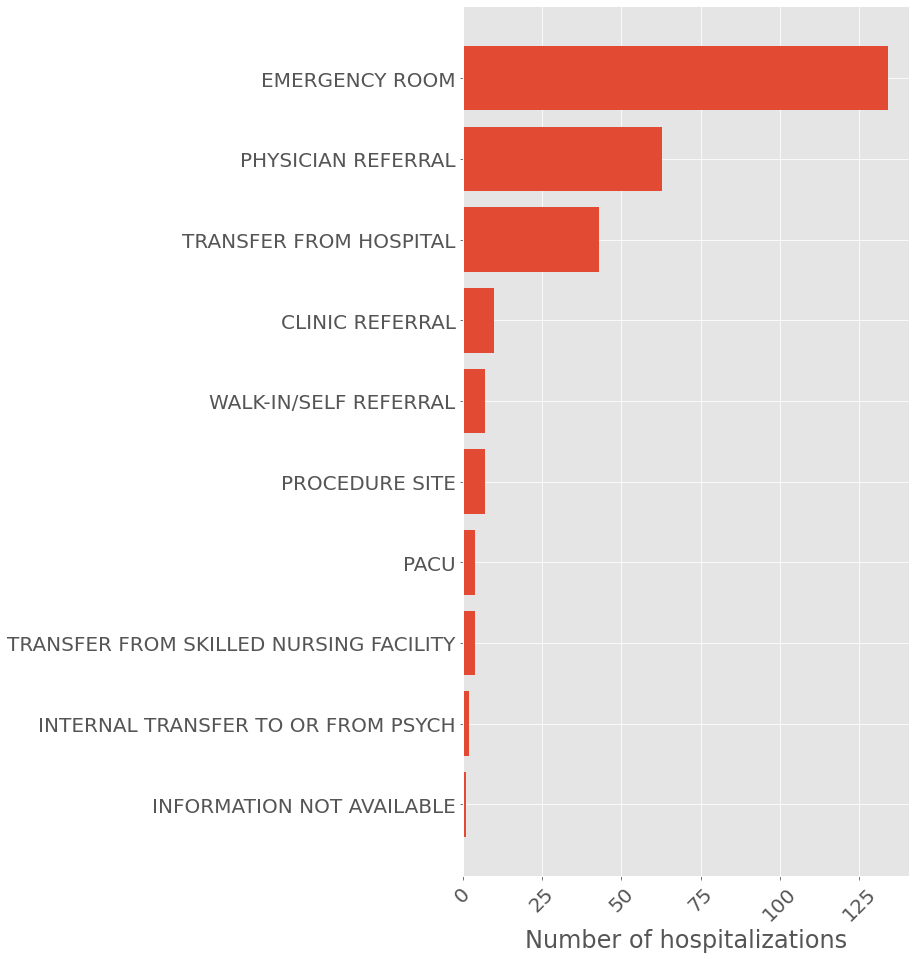

,admission_location,n,%
0,INFORMATION NOT AVAILABLE,1,0.363636
1,INTERNAL TRANSFER TO OR FROM PSYCH,2,0.727273
2,TRANSFER FROM SKILLED NURSING FACILITY,4,1.454545
3,PACU,4,1.454545
4,PROCEDURE SITE,7,2.545455
5,WALK-IN/SELF REFERRAL,7,2.545455
6,CLINIC REFERRAL,10,3.636364
7,TRANSFER FROM HOSPITAL,43,15.636364
8,PHYSICIAN REFERRAL,63,22.909091
9,EMERGENCY ROOM,134,48.727273


In [ ]:
# Load admissions
query = f"""
SELECT admission_location, count(*) as n
FROM `physionet-data.{dataset}_core.admissions` a
WHERE admission_location IS NOT NULL
GROUP BY 1
ORDER BY 2
"""
df = run_query(query)
df['%'] = df['n'] / df['n'].sum() * 100.0

plt.figure(figsize=[8, 16])
plt.barh(df['admission_location'], df['n'])
plt.xlabel('Number of hospitalizations')
plt.xticks(rotation=45)
plt.show()

df

We can see around almost half of patients in MIMIC-IV are admitted via the emergency room. Let's go back to our patient.

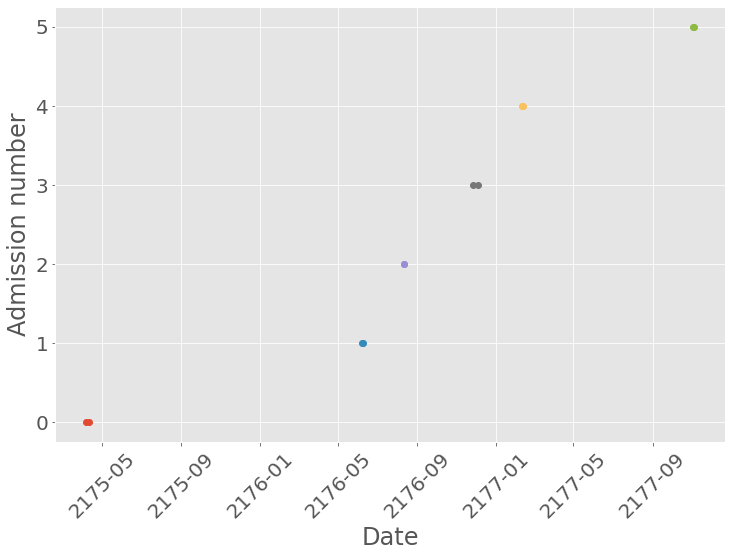

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag
0,10012853,26369609,2175-04-05 15:36:00,2175-04-10 16:55:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Other,ENGLISH,WIDOWED,BLACK/AFRICAN AMERICAN,2175-04-05 06:22:00,2175-04-05 17:10:00,0
1,10012853,22539296,2176-06-06 18:09:00,2176-06-08 18:30:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Medicare,ENGLISH,WIDOWED,BLACK/AFRICAN AMERICAN,2176-06-06 13:33:00,2176-06-06 20:18:00,0
2,10012853,22896692,2176-08-11 15:17:00,2176-08-11 17:35:00,NaT,EU OBSERVATION,EMERGENCY ROOM,None,Medicare,ENGLISH,WIDOWED,BLACK/AFRICAN AMERICAN,2176-08-11 08:36:00,2176-08-11 17:35:00,0
3,10012853,27882036,2176-11-25 21:28:00,2176-12-03 15:24:00,NaT,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,WIDOWED,BLACK/AFRICAN AMERICAN,2176-11-25 18:34:00,2176-11-25 23:51:00,0
4,10012853,26739864,2177-02-11 07:15:00,2177-02-12 16:20:00,NaT,DIRECT OBSERVATION,PHYSICIAN REFERRAL,None,Medicare,ENGLISH,WIDOWED,BLACK/AFRICAN AMERICAN,NaT,NaT,0
5,10012853,20457729,2177-11-03 09:30:00,2177-11-04 15:06:00,NaT,DIRECT OBSERVATION,PHYSICIAN REFERRAL,None,Medicare,ENGLISH,WIDOWED,BLACK/AFRICAN AMERICAN,NaT,NaT,0


In [ ]:
plt.figure(figsize=[12, 8])
for i, row in adm.iterrows():
  plt.plot([row['admittime'], row['dischtime']], [i, i], 'o-')
plt.ylabel('Admission number')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()
adm

The admission table also tells us about their demographics, has the time at which they were registered and discharged from the ED, and whether the patient died in the hospital. If we select their earliest hospitalization, we can use the *transfers* table to track their in-hospital movement, i.e. which wards they stayed in during their hospital stay.

In [ ]:
# Load admissions
query = f"""
SELECT *
FROM `physionet-data.{dataset}_core.transfers` tr
WHERE hadm_id IN
(
  SELECT hadm_id
  FROM `physionet-data.{dataset}_core.admissions`
  WHERE subject_id = {subject_id}
  ORDER BY admittime
  LIMIT 1
)
ORDER BY intime
"""
tr = run_query(query)
tr

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime
0,10012853,26369609,35806219,ED,Emergency Department,2175-04-05 06:22:00,2175-04-05 17:10:00
1,10012853,26369609,35719013,admit,Medicine,2175-04-05 17:10:00,2175-04-10 16:55:29
2,10012853,26369609,39748600,discharge,None,2175-04-10 16:55:29,NaT


The patient was admitted to the emergency department (ED) and spent just under 10 hours in the ED. She then spent five days in a medicine ward until being discharged from the hospital. From the admissions table above, we know that she was discharged home from the hospital (`discharge_location` of 'HOME').

As a large amount of data in MIMIC-IV is focused on a patient's ICU stay, it behooves us to select a hospitalization which involved an ICU stay. To figure out what stays are ICU stays, let's group *transfers* by the careunit.

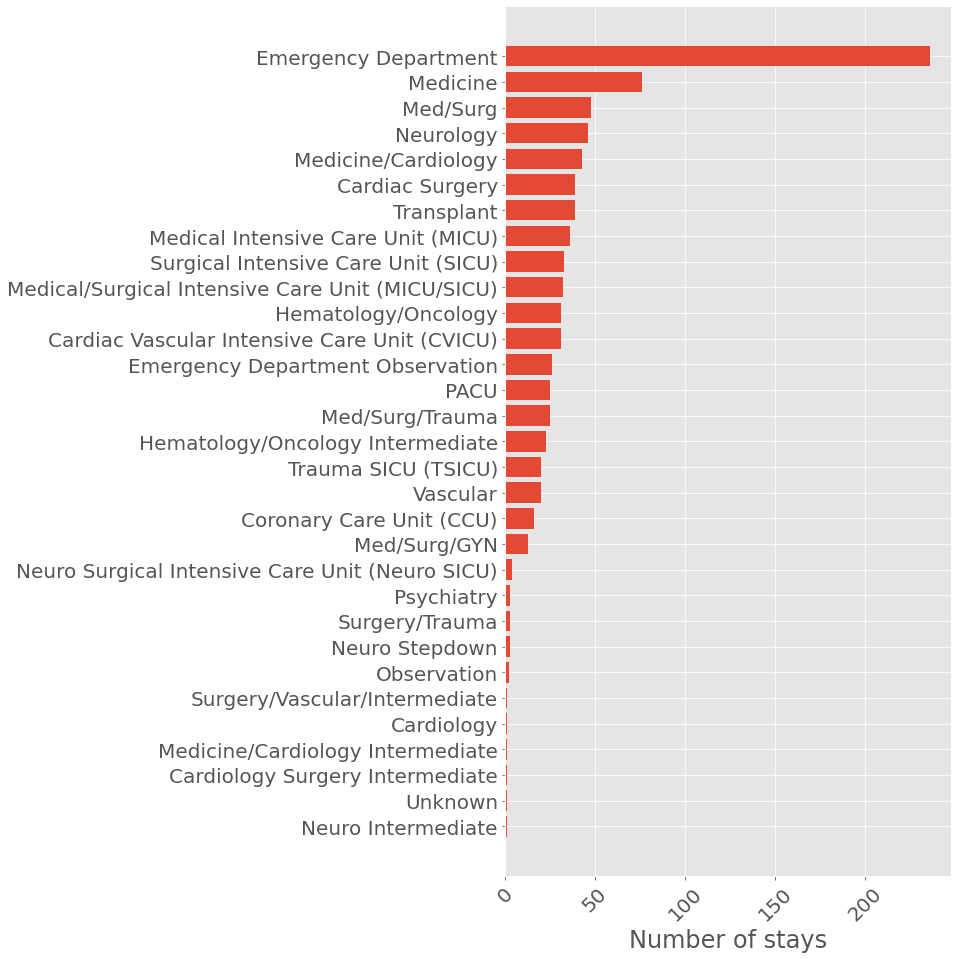

In [ ]:
# Load admissions
query = f"""
SELECT careunit, count(*) AS n
FROM `physionet-data.{dataset}_core.transfers` tr
WHERE careunit IS NOT NULL
GROUP BY 1
ORDER BY 2
"""
df = run_query(query)

plt.figure(figsize=[8, 16])
plt.barh(df['careunit'], df['n'])
plt.xlabel('Number of stays')
plt.xticks(rotation=45)
plt.show()

Above we can see that by far the majority of stays are in the emergency room. This is because the emergency room in the hospital is better thought of as a clinic: many patients have many brief stays.

So, now that we know all the care units, we can simply subselect our patient's hospitalizations to those which contain an ICU stay. Note that patients in MIMIC-IV are *not* guaranteed to have an ICU stay, but we've picked this patient as we know they do have one.

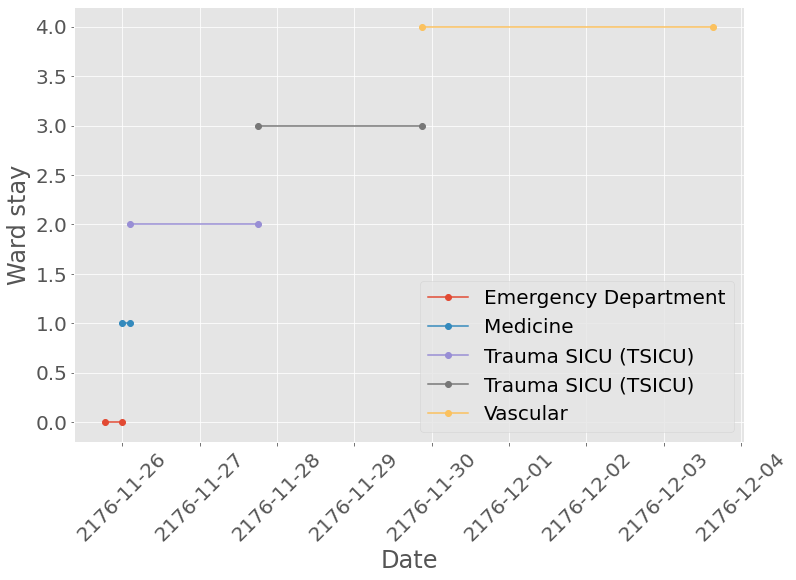

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime
0,10012853,27882036,30056787,ED,Emergency Department,2176-11-25 18:34:00,2176-11-25 23:51:00
1,10012853,27882036,39123440,admit,Medicine,2176-11-25 23:51:00,2176-11-26 02:34:49
2,10012853,27882036,38821082,transfer,Trauma SICU (TSICU),2176-11-26 02:34:49,2176-11-27 18:04:59
3,10012853,27882036,35765117,transfer,Trauma SICU (TSICU),2176-11-27 18:04:59,2176-11-29 20:58:54
4,10012853,27882036,34298098,transfer,Vascular,2176-11-29 20:58:54,2176-12-03 15:24:09
5,10012853,27882036,31995771,discharge,None,2176-12-03 15:24:09,NaT


In [ ]:
# Load admissions
query = f"""
SELECT *
FROM `physionet-data.{dataset}_core.transfers` tr
WHERE hadm_id IN
(
  SELECT hadm_id
  FROM `physionet-data.{dataset}_core.transfers`
  WHERE subject_id = {subject_id}
  AND careunit IN
  (
    'Neuro Surgical Intensive Care Unit (Neuro SICU)',
    'Coronary Care Unit (CCU)',
    'Trauma SICU (TSICU)',
    'Surgical Intensive Care Unit (SICU)',
    'Cardiac Vascular Intensive Care Unit (CVICU)',
    'Medical/Surgical Intensive Care Unit (MICU/SICU)',
    'Medical Intensive Care Unit (MICU)'
    -- exclude NICU - adult patients do not have stays in the NICU
    -- 'Neonatal Intensive Care Unit (NICU)'
  )
)
ORDER BY intime
"""
tr = run_query(query)

# retain hadm_id for later use in queries
hadm_id = tr['hadm_id'].values[0]

# plot the patient stays
plt.figure(figsize=[12, 8])
for i, row in tr.iterrows():
  if pd.isnull(row['outtime']):
    continue
  plt.plot([row['intime'], row['outtime']], [i, i], 'o-', label=row['careunit'])
plt.ylabel('Ward stay')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

tr

As it turns out, this patient has only one hospitalization which contains an ICU stay. The *transfers* table provides us with the patient's full hospital course: they were admitted via the emergency department to a medicine ward in the hospital. As the deidentification approach retains the time of day, we know the patient was transfered at 2:34 AM from the medicine ward to the trauma/surgical intensive care unit (TSICU). The patient spent approximately three days in the TSICU. Note that there are two rows associated with the same care unit (TSICU). This is not an error, and this phenomenon can occur when a patient moves from one physical location to another which have the same designation. In this case, it is likely that the patient moved beds within the same physical location, though it is also possible that the TSICU care unit physically corresponds to more than one room, and the patient was moved between the two rooms. After their stay in the ICU, the patient was transferred to a vascular ward in the hospital. After four days in the vascular ward, the patient is discharged from the hospital. As before, we can investigate their hospital level information in the admissions table.

In [ ]:
# Load admissions
query = f"""
SELECT *
FROM `physionet-data.{dataset}_core.admissions`
WHERE hadm_id = {hadm_id}
"""
adm = run_query(query)
adm.T

,0
subject_id,10012853
hadm_id,27882036
admittime,2176-11-25 21:28:00
dischtime,2176-12-03 15:24:00
deathtime,NaT
admission_type,EW EMER.
admission_location,EMERGENCY ROOM
discharge_location,SKILLED NURSING FACILITY
insurance,Medicare
language,ENGLISH


Above, we can see that the patient was an emergency admission admitted via the emergency room (or emergency department, the terms are usable interchangeably). In this case, the patient is discharged to a skilled nursing facility.

Hopefully you now understand how the *core* dataset can be used to identify and understand patient movement within the hospital. We'll retain this patient's identifiers (`subject_id` and `hadm_id`), and move on to highlighting the information available for the patient in the *hosp*, *icu*, and *cxr* datasets.

## *ed*

Since the patient was admitted through the emergency department, we very likely have their data from the ED! (Very likely because MIMIC-ED and MIMIC-IV do not overlap completely).

Let's check!

In [ ]:
query = f"""
SELECT * FROM `physionet-data.{dataset}_ed.edstays`
where subject_id = {subject_id}
ORDER BY intime
"""
edstays = run_query(query)
edstays

,subject_id,hadm_id,stay_id,intime,outtime
0,10012853,26369609.0,35806219,2175-04-05 06:22:00,2175-04-05 17:10:00
1,10012853,NaN,31766406,2175-04-26 11:38:00,2175-04-26 11:41:00
2,10012853,NaN,33002260,2175-05-29 07:49:00,2175-05-29 08:14:00
3,10012853,22539296.0,30872714,2176-06-06 13:33:00,2176-06-06 20:18:00
4,10012853,22896692.0,30546971,2176-08-11 08:36:00,2176-08-11 17:35:00
5,10012853,NaN,34889141,2176-09-09 08:03:00,2176-09-09 08:33:00
6,10012853,NaN,33643640,2176-10-06 00:32:00,2176-10-06 00:53:00
7,10012853,27882036.0,30056787,2176-11-25 18:34:00,2176-11-25 23:51:00
8,10012853,NaN,37537402,2177-07-11 00:39:00,2177-07-11 00:51:00


We do indeed have quite a few ED stays for this patient. We can subselect to the ED stay associated with the hospitalization we chose earlier by filtering on the `hadm_id`.

In [ ]:
query = f"""
SELECT * FROM `physionet-data.{dataset}_ed.edstays`
where hadm_id = {hadm_id}
ORDER BY intime
"""
edstays = run_query(query)

ed_stay_id = edstays['stay_id'].values[0]

edstays

,subject_id,hadm_id,stay_id,intime,outtime
0,10012853,27882036,30056787,2176-11-25 18:34:00,2176-11-25 23:51:00


In [ ]:
query = f"""
SELECT * FROM `physionet-data.{dataset}_ed.triage`
where stay_id = {ed_stay_id}
"""
triage = run_query(query)
display(triage)

,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,30056787,97.6,72,16,97,173,60,0,2,"DVT, Transfer"


Above we can see that this patient had a chief complaint of a deep vein thrombosis (DVT) and was a transfer patient via the ED. Her vital signs are also shown; note the high systolic blood pressure!

In [ ]:
query = f"""
SELECT * FROM `physionet-data.{dataset}_ed.vitalsign`
where stay_id = {ed_stay_id}
order by charttime
"""
vs = run_query(query)
display(vs)

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain
0,10012853,30056787,2176-11-25 18:37:00,97.6,72,16,97,173.0,60.0,None,0
1,10012853,30056787,2176-11-25 21:00:00,None,65,21,96,NaN,NaN,None,None
2,10012853,30056787,2176-11-25 21:34:00,None,69,21,96,164.0,51.0,None,0
3,10012853,30056787,2176-11-25 21:59:00,98,63,24,94,155.0,50.0,None,0
4,10012853,30056787,2176-11-25 22:46:00,None,71,15,93,163.0,59.0,None,0
5,10012853,30056787,2176-11-25 23:24:00,98.4,77,25,97,164.0,48.0,None,0
6,10012853,30056787,2176-11-25 23:24:00,98.4,77,25,97,164.0,48.0,None,0


The *vitalsign* table contains vital signs noted by nursing staff while the patient was in the ED. Usually you'll see a set of vital signs every 1-4 hours, but in this case it seems the patient was being monitored a bit more frequently; possible because she appeared unwell. Note the reasonably low oxygen saturation (`o2sat`) of 93%. You'll also see most of the columns in this table mirror those of triage.

In [ ]:
query = f"""
SELECT * FROM `physionet-data.{dataset}_ed.medrecon`
where stay_id = {ed_stay_id}
"""
medrecon = run_query(query)
display(medrecon)

,subject_id,stay_id,charttime,name,gsn,ndc,etc_rn,etccode,etcdescription
0,10012853,30056787,2176-11-25 19:45:00,lisinopril,041567,16729019801,1,00000224,ACE Inhibitors
1,10012853,30056787,2176-11-25 19:43:00,aspirin,022159,45802064287,1,00000575,Salicylate Analgesics
2,10012853,30056787,2176-11-25 19:48:00,multivitamin,002524,10770012801,1,00000701,Multivitamins
3,10012853,30056787,2176-11-25 19:48:00,calcium carbonate-vit D3-min,062773,11822489880,1,00000734,Minerals and Electrolytes - Calcium Replacemen...
4,10012853,30056787,2176-11-25 19:47:00,ferrous sulfate,062753,54868632400,1,00000785,Minerals and Electrolytes - Iron
5,10012853,30056787,2176-11-25 19:46:00,Coumadin,006561,15330010101,1,00000806,Anticoagulants - Coumarin
6,10012853,30056787,2176-11-25 19:46:00,Coumadin,018080,15330026601,1,00000806,Anticoagulants - Coumarin
7,10012853,30056787,2176-11-25 19:42:00,amiodarone,017241,16714084301,1,00002734,Antiarrhythmic - Class III
8,10012853,30056787,2176-11-25 19:46:00,atorvastatin,029969,10135065110,1,00002747,Antihyperlipidemic - HMG CoA Reductase Inhibit...
9,10012853,30056787,2176-11-25 19:43:00,amlodipine,016926,10135052503,1,00004609,Calcium Channel Blockers - Dihydropyridines


Above we can see the medicine reconciliation table, or *medrecon*. This is a list of medications which the patient is taking at home. In this case, the patient is on 11 medications, ranging from aspirin to methimazole. Note also that the `etccode` and `etcdescription` columns provide a useful classification of the type of medication. There may be more than one `etccode` for a single medication, and the `etc_rn` column helps us differentiate between those medications.

In [ ]:
query = f"""
SELECT * FROM `physionet-data.{dataset}_ed.diagnosis`
where stay_id = {ed_stay_id}
"""
eddx = run_query(query)
display(eddx)

,subject_id,stay_id,seq_num,icd_code,icd_title
0,10012853,30056787,1,I82.622,Acute embolism and thrombosis of deep veins of...


Finally the *diagnosis* table provides us with the diagnoses which the patient was billed for **after leaving the ED**.

## *hosp*

The *hosp* dataset contains information sourced from the hospital electronic health record (EHR) system. There are many tables in this dataset, but we can group the data contained as follows:

* Service data: the hospital service the patient was under during their hospital stay, e.g. medicine, surgery, etc.
  * *services*
* Order data: orders made for the patient including treatments, code status, and so on
  * *poe*, *poe_detail*
* Microbiology studies: blood cultures, antibiotic sensitivities, and other similar tests
  * *d_micro*, *microbiologyevents*
* Laboratory data: information measured on a specimen derived from the patient, e.g. the electrolytes in a sample of patient blood
  * *d_labitems*, *labevents*
* Medication data: information about the prescription and administration of drugs/compounds to the patient
  * *prescriptions*, *pharmacy*, *emar*, *emar_detail*
* Billing data: trained personelle assign coded terms to a patient's hospitalization to facilitate the billing process
  * *d_hcpcs*, *hcpcsevents*, *d_icd_diagnoses*, *diagnoses_icd*, *d_icd_procedures*, *procedures_icd*, *drgcodes*

We'll now go through these tables and subselect to our example patient.

### *services*

In [ ]:
# services
query = f"""
WITH t1 AS
(
SELECT hadm_id, count(*) as n
FROM `physionet-data.{dataset}_hosp.services`
GROUP BY 1
)
SELECT n AS n_service
, count(*) AS n
FROM t1
GROUP BY 1
ORDER BY 1
"""
df = run_query(query)
df['%'] = df['n'] / df['n'].sum() * 100.0
display(df.head())

query = f"""
SELECT *
FROM `physionet-data.{dataset}_hosp.services`
WHERE hadm_id = {hadm_id}
"""
serv = run_query(query)
serv.T

,n_service,n,%
0,1,240,87.272727
1,2,26,9.454545
2,3,9,3.272727


,0
subject_id,10012853
hadm_id,27882036
transfertime,2173-03-29 21:28:30
prev_service,None
curr_service,MED


The *services* table is fairly straightforward. Around 94% of patients are assigned a single service for their entire hospital stay. In this case, the patient has the "MED" service, which is short for medical.

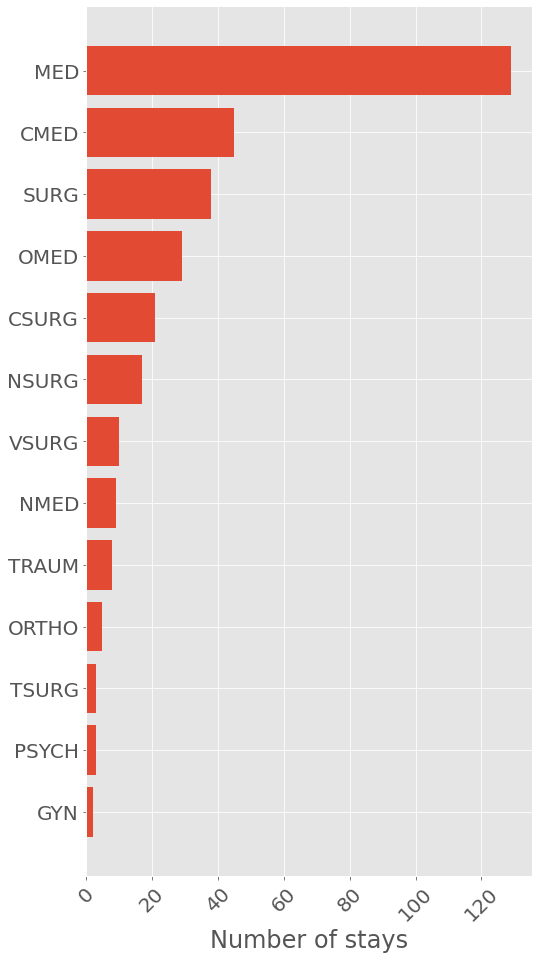

In [ ]:
query = f"""
SELECT curr_service AS service, count(*) as n
FROM `physionet-data.{dataset}_hosp.services`
GROUP BY 1
ORDER BY 2
"""
df = run_query(query)

plt.figure(figsize=[8, 16])
plt.barh(df['service'], df['n'])
plt.xlabel('Number of stays')
plt.xticks(rotation=45)
plt.show()

### *poe*, *poe_detail*

There is a soft convention in MIMIC-IV tables that a "_detail" table provides more information for an identifier in its corresponding primary table. In this case, the *poe* table provides information about provider orders, and the *poe_detail* table provides further information about the orders in the *poe* table. An example will hopefully elucidate this further.

In [ ]:
query = f"""
SELECT *
FROM `physionet-data.{dataset}_hosp.poe`
WHERE hadm_id = {hadm_id}
ORDER BY poe_seq
"""
poe = run_query(query)
poe[['subject_id', 'poe_id', 'poe_seq', 'ordertime', 'order_type', 'order_subtype']]

,subject_id,poe_id,poe_seq,ordertime,order_type,order_subtype
0,10012853,10012853-195,195,2176-11-25 19:13:27,Radiology,Ultrasound
1,10012853,10012853-196,196,2176-11-25 20:51:17,Lab,None
2,10012853,10012853-197,197,2176-11-25 20:51:17,Lab,None
3,10012853,10012853-198,198,2176-11-25 21:09:30,Radiology,CT Scan
4,10012853,10012853-199,199,2176-11-25 21:34:36,Medications,None
...,...,...,...,...,...,...
193,10012853,10012853-396,396,2176-12-03 13:33:38,ADT orders,Discharge
194,10012853,10012853-397,397,2176-12-03 13:38:52,ADT orders,Discharge
195,10012853,10012853-398,398,2176-12-03 13:38:52,ADT orders,Discharge
196,10012853,10012853-399,399,2176-12-03 13:39:23,ADT orders,Discharge


The patient has 198 orders over their stay. The `order_type` and `order_subtype` give us an idea of what type of orders are made.

In [ ]:
poe.groupby(['order_type', 'order_subtype'])[['poe_id']].count()

poe_id
order_type   order_subtype                         
ADT orders   Admit                                2
             Discharge                            6
             Transfer                             2
Blood Bank   Blood tests                          1
Cardiology   ECG                                  1
Consults     Discharge Followup Appointment       1
             Physical Therapy                     2
             Speech/Swallowing                    1
General Care Activity                             5
             Code status                          3
             Other                                4
             Telemetry                            5
             Tubes/Drains                         5
             Vitals/Monitoring                    4
IV therapy   IV access                            6
             IV access request                    2
             IV fluids                           10
Nutrition    Diet Order                           7
Radiology    CT Scan                              2
             General Xray                         2
             Interventional Radiology             4
             Ultrasound                           1
Respiratory  BiPAP                                3
             CPAP for OSA                         2

We can see:

1. There are a number of orders for the management of the patients movement in the hospital (commonly abbreviated ADT for admission/discharge/transfer)
2. The patient has had physical therapy consults
3. Various imaging studies have been ordered including CT scans and x-rays
4. The patient was on non-invasive ventilation (BiPAP order)


In [ ]:
query = f"""
SELECT p.*, pd.field_name, pd.field_value
FROM `physionet-data.{dataset}_hosp.poe` p
INNER JOIN `physionet-data.{dataset}_hosp.poe_detail` pd
  ON p.poe_id = pd.poe_id
WHERE hadm_id = {hadm_id}
ORDER BY poe_seq
"""
poedet = run_query(query)
poedet[['subject_id', 'poe_id', 'ordertime', 'order_type', 'order_subtype', 'field_name', 'field_value']]

,subject_id,poe_id,ordertime,order_type,order_subtype,field_name,field_value
0,10012853,10012853-203,2176-11-26 00:09:39,ADT orders,Admit,Admit category,Place in observation
1,10012853,10012853-209,2176-11-26 01:32:13,ADT orders,Admit,Admit category,Admit to inpatient
2,10012853,10012853-215,2176-11-26 01:32:13,General Care,Tubes/Drains,Tubes & Drains type,Indwelling urinary catheter (IUC) - Foley
3,10012853,10012853-223,2176-11-26 01:45:45,General Care,Code status,Code status,Resuscitate (Full code)
4,10012853,10012853-225,2176-11-26 03:09:58,ADT orders,Transfer,Transfer to,MICU - Orange
5,10012853,10012853-225,2176-11-26 03:09:58,ADT orders,Transfer,Admit category,Admit to inpatient
6,10012853,10012853-232,2176-11-26 03:09:58,General Care,Code status,Code status,Resuscitate (Full code)
7,10012853,10012853-295,2176-11-27 12:39:20,IV therapy,IV access request,Indication,Hydration
8,10012853,10012853-337,2176-11-29 21:55:48,ADT orders,Transfer,Admit category,Admit to inpatient
9,10012853,10012853-359,2176-11-29 21:55:48,General Care,Code status,Code status,Resuscitate (Full code)


### *d_micro*, *microbiologyevents*

Another commonly found convention in MIMIC-IV is the use of an "events" table with a "d_" table. This is a type of database normalization, where information is encoded as an integer and stored elsewhere.

In [ ]:
query = f"""
SELECT *
FROM `physionet-data.{dataset}_hosp.microbiologyevents`
WHERE hadm_id = {hadm_id}
"""
micro = run_query(query)
micro

,microevent_id,subject_id,hadm_id,micro_specimen_id,chartdate,charttime,spec_itemid,test_seq,storedate,storetime,test_itemid,test_name,org_itemid,isolate_num,quantity,ab_itemid,dilution_text,dilution_comparison,dilution_value,interpretation


As it turns out, this patient did not have any microbiology information during this hospitalization. This is to be expected - not all patients receive every test! We can look across the patient's entire record, rather than just within this hospitalization.

In [ ]:
query = f"""
SELECT *
FROM `physionet-data.{dataset}_hosp.microbiologyevents`
WHERE subject_id = {subject_id}
ORDER BY chartdate, charttime
"""
micro = run_query(query)
micro

,microevent_id,subject_id,hadm_id,micro_specimen_id,chartdate,charttime,spec_itemid,test_seq,storedate,storetime,test_itemid,test_name,org_itemid,isolate_num,quantity,ab_itemid,dilution_text,dilution_comparison,dilution_value,interpretation
0,4669,10012853,NaN,9742577,2175-04-05,NaT,70079,1,2175-04-07,2175-04-07 11:47:00,90039,URINE CULTURE,80004.0,1.0,None,90010.0,64,=,64.00,I
1,4674,10012853,NaN,9742577,2175-04-05,NaT,70079,1,2175-04-07,2175-04-07 11:47:00,90039,URINE CULTURE,80004.0,1.0,None,90019.0,<=0.25,<=,0.25,S
2,4671,10012853,NaN,9742577,2175-04-05,NaT,70079,1,2175-04-07,2175-04-07 11:47:00,90039,URINE CULTURE,80004.0,1.0,None,90013.0,<=1,<=,1.00,S
3,4677,10012853,NaN,9742577,2175-04-05,NaT,70079,1,2175-04-07,2175-04-07 11:47:00,90039,URINE CULTURE,80004.0,1.0,None,90028.0,<=1,<=,1.00,S
4,4676,10012853,NaN,9742577,2175-04-05,NaT,70079,1,2175-04-07,2175-04-07 11:47:00,90039,URINE CULTURE,80004.0,1.0,None,90026.0,<=4,<=,4.00,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,4711,10012853,NaN,8328091,2176-10-06,2176-10-06 02:37:00,70079,1,2176-10-10,2176-10-10 14:17:00,90039,URINE CULTURE,80018.0,1.0,None,90012.0,<=1,<=,1.00,S
61,4716,10012853,NaN,8328091,2176-10-06,2176-10-06 02:37:00,70079,1,2176-10-10,2176-10-10 14:17:00,90039,URINE CULTURE,80018.0,1.0,None,90026.0,<=4,<=,4.00,S
62,4713,10012853,NaN,8328091,2176-10-06,2176-10-06 02:37:00,70079,1,2176-10-10,2176-10-10 14:17:00,90039,URINE CULTURE,80018.0,1.0,None,90017.0,None,None,NaN,S
63,4715,10012853,NaN,8328091,2176-10-06,2176-10-06 02:37:00,70079,1,2176-10-10,2176-10-10 14:17:00,90039,URINE CULTURE,80018.0,1.0,None,90019.0,<=0.25,<=,0.25,S


The patient has 65 records in *microbiologyevents* table. Recall that the patient's admission for the hospital stay we are examining occurred on 2176-11-25 21:28:00. We can see that about two months prior to the admission (2176-10-10), the patient had a urine culture (`test_name`), which tested positive for multiple organisms (`org_itemid` is non-null). This raises an important point about the microbiology table and data in the *hosp* dataset in general: while the information is sourced from the hospital, **the dataset also contains data collected outside of the hospital**. This is particularly useful when you'd like to search for baseline data prior to their hospitalization.

To better understand the micro data, let's subselect to urine culture specimen.

In [ ]:
micro.loc[micro['micro_specimen_id'] == 8328091].T

,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
microevent_id,4727,4712,4709,4724,4725,4720,4728,4722,4718,4714,4717,4726,4721,4723,4710,4719,4711,4716,4713,4715
subject_id,10012853,10012853,10012853,10012853,10012853,10012853,10012853,10012853,10012853,10012853,10012853,10012853,10012853,10012853,10012853,10012853,10012853,10012853,10012853,10012853
hadm_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
micro_specimen_id,8328091,8328091,8328091,8328091,8328091,8328091,8328091,8328091,8328091,8328091,8328091,8328091,8328091,8328091,8328091,8328091,8328091,8328091,8328091,8328091
chartdate,2176-10-06 00:00:00,2176-10-06 00:00:00,2176-10-06 00:00:00,2176-10-06 00:00:00,2176-10-06 00:00:00,2176-10-06 00:00:00,2176-10-06 00:00:00,2176-10-06 00:00:00,2176-10-06 00:00:00,2176-10-06 00:00:00,2176-10-06 00:00:00,2176-10-06 00:00:00,2176-10-06 00:00:00,2176-10-06 00:00:00,2176-10-06 00:00:00,2176-10-06 00:00:00,2176-10-06 00:00:00,2176-10-06 00:00:00,2176-10-06 00:00:00,2176-10-06 00:00:00
charttime,2176-10-06 02:37:00,2176-10-06 02:37:00,2176-10-06 02:37:00,2176-10-06 02:37:00,2176-10-06 02:37:00,2176-10-06 02:37:00,2176-10-06 02:37:00,2176-10-06 02:37:00,2176-10-06 02:37:00,2176-10-06 02:37:00,2176-10-06 02:37:00,2176-10-06 02:37:00,2176-10-06 02:37:00,2176-10-06 02:37:00,2176-10-06 02:37:00,2176-10-06 02:37:00,2176-10-06 02:37:00,2176-10-06 02:37:00,2176-10-06 02:37:00,2176-10-06 02:37:00
spec_itemid,70079,70079,70079,70079,70079,70079,70079,70079,70079,70079,70079,70079,70079,70079,70079,70079,70079,70079,70079,70079
test_seq,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
storedate,2176-10-10 00:00:00,2176-10-10 00:00:00,2176-10-10 00:00:00,2176-10-10 00:00:00,2176-10-10 00:00:00,2176-10-10 00:00:00,2176-10-10 00:00:00,2176-10-10 00:00:00,2176-10-10 00:00:00,2176-10-10 00:00:00,2176-10-10 00:00:00,2176-10-10 00:00:00,2176-10-10 00:00:00,2176-10-10 00:00:00,2176-10-10 00:00:00,2176-10-10 00:00:00,2176-10-10 00:00:00,2176-10-10 00:00:00,2176-10-10 00:00:00,2176-10-10 00:00:00
storetime,2176-10-10 14:17:00,2176-10-10 14:17:00,2176-10-10 14:17:00,2176-10-10 14:17:00,2176-10-10 14:17:00,2176-10-10 14:17:00,2176-10-10 14:17:00,2176-10-10 14:17:00,2176-10-10 14:17:00,2176-10-10 14:17:00,2176-10-10 14:17:00,2176-10-10 14:17:00,2176-10-10 14:17:00,2176-10-10 14:17:00,2176-10-10 14:17:00,2176-10-10 14:17:00,2176-10-10 14:17:00,2176-10-10 14:17:00,2176-10-10 14:17:00,2176-10-10 14:17:00


Above we can see we actually have many rows for a single `micro_specimen_id`. This is expected, and there are a few different ways which data can present itself in this table. Recall that the intention of a microbiology test is to determine if an organism is present in a sample. In this case, the same is urine. The possibilities are:

* If no growth is found, the `org_itemid` and subsequent columns will be NULL, and there will only be a single row for the `micro_specimen_id`
* If an organism is found, then each organism will be present as a single row. Each unique organism is assigned a unique `org_itemid`, and *d_micro* provides the interpretable name for these organisms.
* If antibiotics are tested on a given organism, then additional rows will be present for combination of antibiotic and organism (i.e. a single antibiotic denoted by `ab_itemid` may be tested on the one or more organisms which grew). Antibiotic parameters and sensitivities are present in the remaining columns (`dilution_text`, `dilution_comparison`, `dilution_value`, `interpretation`).

Back to our patient, we can re-run a query joining to *d_micro* to get the interpretable names of the organisms and antibiotics associated with the specimen.

In [ ]:
micro_specimen_id = 8328091

query = f"""
SELECT
me.subject_id, me.hadm_id
, me.micro_specimen_id
, me.charttime, me.storetime
, me.test_seq
, me.test_name
, me.test_itemid
, test.label as test_label
, me.org_itemid
, org.label as org_label
, me.isolate_num, me.quantity
, me.ab_itemid
, ab.label as ab_label
, me.dilution_text, me.dilution_comparison
, me.dilution_value, me.interpretation
FROM `physionet-data.{dataset}_hosp.microbiologyevents` me
INNER JOIN `physionet-data.{dataset}_hosp.d_micro` test
  ON me.test_itemid = test.itemid
INNER JOIN `physionet-data.{dataset}_hosp.d_micro` org
  ON me.org_itemid = org.itemid
INNER JOIN `physionet-data.{dataset}_hosp.d_micro` ab
  ON me.ab_itemid = ab.itemid
WHERE micro_specimen_id = {micro_specimen_id}
ORDER BY charttime, org_itemid, ab_itemid
"""
micro = run_query(query)

# only display a subset of columns for conciseness
print('Columns in table: {}'.format(', '.join(micro.columns)))
cols = ['subject_id', 'charttime', 'storetime', 'test_name', 'org_label', 'ab_label',
        'dilution_text', 'interpretation']
micro[cols]

Columns in table: subject_id, hadm_id, micro_specimen_id, charttime, storetime, test_seq, test_name, test_itemid, test_label, org_itemid, org_label, isolate_num, quantity, ab_itemid, ab_label, dilution_text, dilution_comparison, dilution_value, interpretation


,subject_id,charttime,storetime,test_name,org_label,ab_label,dilution_text,interpretation
0,10012853,2176-10-06 02:37:00,2176-10-10 14:17:00,URINE CULTURE,MORGANELLA MORGANII,TRIMETHOPRIM/SULFA,<=1,S
1,10012853,2176-10-06 02:37:00,2176-10-10 14:17:00,URINE CULTURE,MORGANELLA MORGANII,NITROFURANTOIN,128,R
2,10012853,2176-10-06 02:37:00,2176-10-10 14:17:00,URINE CULTURE,MORGANELLA MORGANII,GENTAMICIN,<=1,S
3,10012853,2176-10-06 02:37:00,2176-10-10 14:17:00,URINE CULTURE,MORGANELLA MORGANII,TOBRAMYCIN,<=1,S
4,10012853,2176-10-06 02:37:00,2176-10-10 14:17:00,URINE CULTURE,MORGANELLA MORGANII,CEFTAZIDIME,None,S
5,10012853,2176-10-06 02:37:00,2176-10-10 14:17:00,URINE CULTURE,MORGANELLA MORGANII,CEFTRIAXONE,<=1,S
6,10012853,2176-10-06 02:37:00,2176-10-10 14:17:00,URINE CULTURE,MORGANELLA MORGANII,CIPROFLOXACIN,<=0.25,S
7,10012853,2176-10-06 02:37:00,2176-10-10 14:17:00,URINE CULTURE,MORGANELLA MORGANII,PIPERACILLIN/TAZO,<=4,S
8,10012853,2176-10-06 02:37:00,2176-10-10 14:17:00,URINE CULTURE,MORGANELLA MORGANII,CEFEPIME,<=1,S
9,10012853,2176-10-06 02:37:00,2176-10-10 14:17:00,URINE CULTURE,MORGANELLA MORGANII,MEROPENEM,<=0.25,S


Above, we can see there are two organisms found in the urine culture: morganella morganii and providencia stuartii. Both organisms have been tested for sensitivity against a number of antibiotics (nitrofurantoin, gentamicin, tobramycin, ciprofloxacin). Both organisms are resistant ('R') to nitrofurantoin (note the distinct dilutions used!), but susceptible to all other antibiotics ('S').

### *d_labitems*, *labevents*

In [ ]:
query = f"""
SELECT *
FROM `physionet-data.{dataset}_hosp.labevents`
WHERE hadm_id = {hadm_id}
ORDER BY charttime
"""
lab = run_query(query)
lab

,labevent_id,subject_id,hadm_id,specimen_id,itemid,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,162637,10012853,27882036,8164900,52028,2176-11-26 01:52:00,2176-11-26 01:54:00,ART.,NaN,None,NaN,NaN,None,None,ART.
1,162635,10012853,27882036,8164900,50820,2176-11-26 01:52:00,2176-11-26 01:55:00,7.29,7.29,units,7.35,7.45,abnormal,None,None
2,162636,10012853,27882036,8164900,50821,2176-11-26 01:52:00,2176-11-26 01:55:00,77,77.00,mm Hg,85.00,105.00,abnormal,None,None
3,162634,10012853,27882036,8164900,50818,2176-11-26 01:52:00,2176-11-26 01:55:00,74,74.00,mm Hg,35.00,45.00,abnormal,None,VERIFIED. PROVIDER NOTIFIED PER CURRENT LAB P...
4,162631,10012853,27882036,8164900,50802,2176-11-26 01:52:00,2176-11-26 01:55:00,5,5.00,mEq/L,NaN,NaN,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,162933,10012853,27882036,67984366,50983,2176-12-03 07:40:00,2176-12-03 09:40:00,142,142.00,mEq/L,133.00,145.00,None,ROUTINE,None
299,162926,10012853,27882036,67984366,50868,2176-12-03 07:40:00,2176-12-03 09:40:00,12,12.00,mEq/L,8.00,20.00,None,ROUTINE,None
300,162914,10012853,27882036,44221738,51274,2176-12-03 07:40:00,2176-12-03 08:53:00,12.0,12.00,sec,9.40,12.50,None,ROUTINE,None
301,162915,10012853,27882036,44221738,51275,2176-12-03 07:40:00,2176-12-03 08:53:00,29.2,29.20,sec,25.00,36.50,None,ROUTINE,None


Laboratory data contains measurements made from human derived specimens (urine samples, blood samples, sputum samples, etc). When a sample is drawn, it is assigned a unique `specimen_id`. Measurements made from this sample will be associated with the same `specimen_id`. For example, a measurement of sodium and potassium made on the same blood sample will appear as two rows with the same `specimen_id`.

In order to understand the measurements made, it's useful to join the *labevents* table to the *d_labitems* table, which has descriptive information for each type of lab measurement.

In [ ]:
query = f"""
SELECT le.hadm_id
, le.specimen_id
, le.charttime
, le.storetime
, le.itemid
, dl.fluid
, dl.category
, dl.label
, le.value
, le.valuenum
, le.valueuom
, le.ref_range_lower, le.ref_range_upper
, le.flag, le.priority
, le.comments
FROM `physionet-data.{dataset}_hosp.labevents` le
INNER JOIN `physionet-data.{dataset}_hosp.d_labitems` dl
  ON le.itemid = dl.itemid
WHERE hadm_id = {hadm_id}
ORDER BY charttime, label
"""
lab = run_query(query)
lab

,hadm_id,specimen_id,charttime,storetime,itemid,fluid,category,label,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,27882036,8164900,2176-11-26 01:52:00,2176-11-26 01:55:00,50802,Blood,Blood Gas,Base Excess,5,5.00,mEq/L,NaN,NaN,None,None,None
1,27882036,8164900,2176-11-26 01:52:00,2176-11-26 01:55:00,50804,Blood,Blood Gas,Calculated Total CO2,37,37.00,mEq/L,21.0,30.0,abnormal,None,None
2,27882036,8164900,2176-11-26 01:52:00,2176-11-26 01:56:00,50813,Blood,Blood Gas,Lactate,0.7,0.70,mmol/L,0.5,2.0,None,None,None
3,27882036,8164900,2176-11-26 01:52:00,2176-11-26 01:54:00,52028,Blood,Blood Gas,Specimen Type,ART.,NaN,None,NaN,NaN,None,None,ART.
4,27882036,8164900,2176-11-26 01:52:00,2176-11-26 01:55:00,50818,Blood,Blood Gas,pCO2,74,74.00,mm Hg,35.0,45.0,abnormal,None,VERIFIED. PROVIDER NOTIFIED PER CURRENT LAB P...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,27882036,56657858,2176-12-03 07:40:00,2176-12-03 09:05:00,52167,Blood,Hematology,RDW-SD,54.6,54.60,fL,35.1,46.3,abnormal,ROUTINE,None
299,27882036,56657858,2176-12-03 07:40:00,2176-12-03 09:05:00,51279,Blood,Hematology,Red Blood Cells,3.84,3.84,m/uL,3.9,5.2,abnormal,ROUTINE,None
300,27882036,67984366,2176-12-03 07:40:00,2176-12-03 09:40:00,50983,Blood,Chemistry,Sodium,142,142.00,mEq/L,133.0,145.0,None,ROUTINE,None
301,27882036,67984366,2176-12-03 07:40:00,2176-12-03 09:40:00,51006,Blood,Chemistry,Urea Nitrogen,10,10.00,mg/dL,6.0,20.0,None,ROUTINE,None


We can now see the added information from *d_labitems*: each lab measurement (`itemid`) is associated with a fluid (the type of specimen it corresponds to) and a category (broad description of the type of lab). It's important to factor in this information: though two labs may be labelled as "pH", one may refer to urine pH while the other refers to blood pH. The value of these measurements have very different reference ranges and interpretations - and this is one of the reasons why MIMIC-IV stores measurements with an `itemid` rather than a textual label.

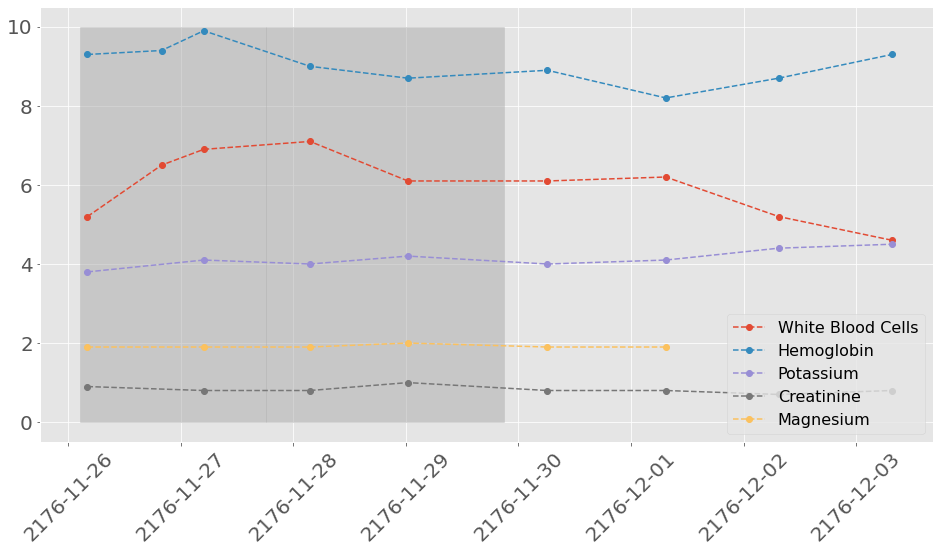

In [ ]:
plt.figure(figsize=[16, 8])

# labs
lab_labels = [
  'White Blood Cells',
  'Hemoglobin',
  'Potassium',
  'Creatinine',
  'Magnesium'
]
for label in lab_labels:
  idx = (lab['label'] == label) & (lab['fluid'] == 'Blood')
  plt.plot(lab.loc[idx, 'charttime'], lab.loc[idx, 'valuenum'], 'o--',  label=f'{label}')

plt.legend(fontsize=16, loc='lower right')
#plt.xlim(['2110-09-07 00:00:00', '2110-09-09 00:00:00'])
plt.xticks(rotation=45)

# shade in their ICU stay
for i, row in tr.iterrows():
  if row['careunit'] is None:
    continue
  if 'ICU' in row['careunit']:
    plt.fill_between([row['intime'], row['outtime']], [0, 0], [10, 10], color='#ababab', alpha=0.5)

plt.show()

Everything looks pretty normal here! Let's take a look at a different type of lab: a blood gas. These are bedside measurements of blood which provide primarily inform about the partial pressure of various gases in the blood (e.g. oxygen, carbon dioxide).

In [ ]:
lab.loc[lab['category'] == 'Blood Gas', 'label'].value_counts()

pO2                     8
Specimen Type           8
Calculated Total CO2    8
pH                      8
pCO2                    8
Base Excess             8
Lactate                 4
Free Calcium            3
Name: label, dtype: int64

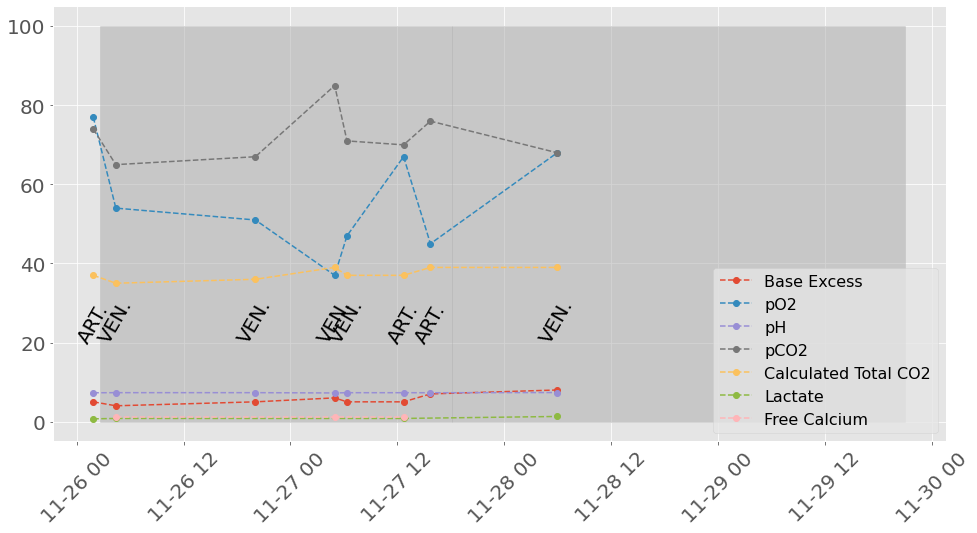

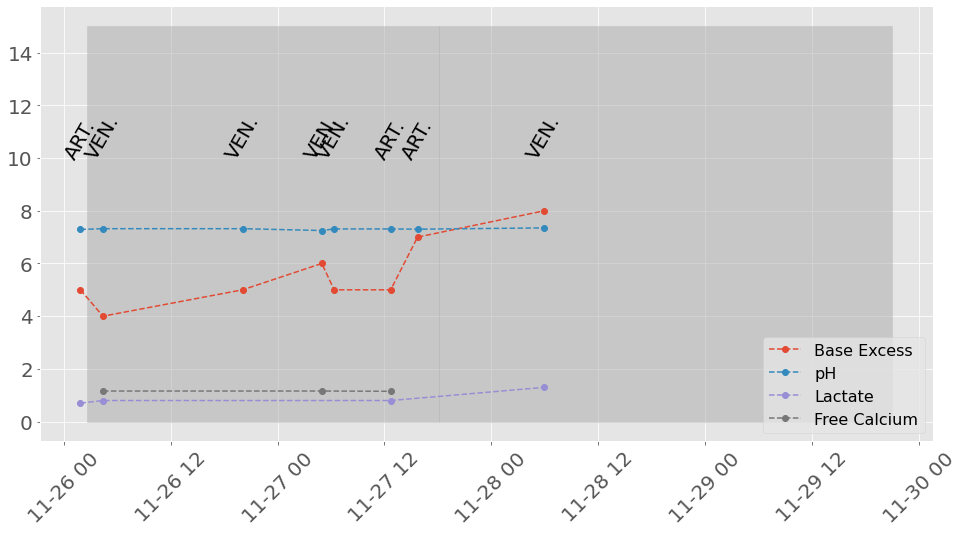

In [ ]:
plt.figure(figsize=[16, 8])

# labs
lab_labels = [
  'Base Excess',
  'pO2',
  'pH',
  'pCO2',
  'Calculated Total CO2',
  'Lactate',
  'Free Calcium',
]

for label in lab_labels:
  idx = (lab['label'] == label) & (lab['fluid'] == 'Blood')
  plt.plot(lab.loc[idx, 'charttime'], lab.loc[idx, 'valuenum'], 'o--',  label=f'{label}')

# add specimen type
for i, row in lab.loc[lab['label'] == 'Specimen Type'].iterrows():
  plt.text(row['charttime'], 20, row['value'], rotation=60, ha='center')

plt.legend(fontsize=16, loc='lower right')
#plt.xlim(['2110-09-07 00:00:00', '2110-09-09 00:00:00'])
plt.xticks(rotation=45)

# shade in their ICU stay
for i, row in tr.iterrows():
  if row['careunit'] is None:
    continue
  if 'ICU' in row['careunit']:
    plt.fill_between([row['intime'], row['outtime']], [0, 0], [100, 100], color='#ababab', alpha=0.5)

plt.show()

# same plot, but ignore a few labels
plt.figure(figsize=[16, 8])

# labs
lab_labels = [
  'Base Excess',
  'pH',
  'Lactate',
  'Free Calcium',
]

for label in lab_labels:
  idx = (lab['label'] == label) & (lab['fluid'] == 'Blood')
  plt.plot(lab.loc[idx, 'charttime'], lab.loc[idx, 'valuenum'], 'o--',  label=f'{label}')

# add specimen type
for i, row in lab.loc[lab['label'] == 'Specimen Type'].iterrows():
  plt.text(row['charttime'], 10, row['value'], rotation=60, ha='center')

plt.legend(fontsize=16, loc='lower right')
#plt.xlim(['2110-09-07 00:00:00', '2110-09-09 00:00:00'])
plt.xticks(rotation=45)

# shade in their ICU stay
for i, row in tr.iterrows():
  if row['careunit'] is None:
    continue
  if 'ICU' in row['careunit']:
    plt.fill_between([row['intime'], row['outtime']], [0, 0], [15, 15], color='#ababab', alpha=0.5)

plt.show()

### *prescriptions*, *pharmacy*, *emar*, *emar_detail*

These tables record medications given to the patient.

* The *prescriptions* table tracks medication orders, i.e. the intention for a patient to receive a medication (and almost all do receive it!)
* The *pharmacy* table provides further detail about the formulation of the prescribed medication
* The *emar* and *emar_detail* tables, short of electronic medication administration record, record actual administration of medications

The *emar* and *emar_detail* are sourced from barcode scanning of physical medications at the time of their administration. As a result, they provide a rich and highly granular record of a patient's medications. Note however that eMAR data is not available for all patients as the system was implemented during the collection period of MIMIC-IV. The patient we have selected does have eMAR during their hospital stay, which we can confirm with a query.

First, let's look at snapshots of these tables.

In [ ]:
query = f"""
SELECT *
FROM `physionet-data.{dataset}_hosp.prescriptions`
WHERE hadm_id = {hadm_id}
ORDER BY starttime
"""
pr = run_query(query)
display(pr.head())

query = f"""
SELECT *
FROM `physionet-data.{dataset}_hosp.pharmacy`
WHERE hadm_id = {hadm_id}
ORDER BY starttime
"""
ph = run_query(query)
display(ph.head())

query = f"""
SELECT *
FROM `physionet-data.{dataset}_hosp.emar`
WHERE hadm_id = {hadm_id}
ORDER BY charttime
"""
emar = run_query(query)
display(emar.head())

query = f"""
SELECT det.*
FROM `physionet-data.{dataset}_hosp.emar_detail` det
INNER JOIN `physionet-data.{dataset}_hosp.emar` e
  ON det.emar_id = e.emar_id
WHERE e.hadm_id = {hadm_id}
ORDER BY emar_seq
"""
emardet = run_query(query)
display(emardet.head())

,subject_id,hadm_id,pharmacy_id,starttime,stoptime,drug_type,drug,gsn,ndc,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route
0,10012853,27882036,79252552,2176-11-26 01:00:00,2176-11-26 03:00:00,BASE,5% Dextrose,None,0,HEPARIN BASE,None,250,mL,250,mL,NaN,IV
1,10012853,27882036,79252552,2176-11-26 01:00:00,2176-11-26 03:00:00,MAIN,Heparin Sodium,060301,00264958720,"25,000 unit Premix Bag",,"25,000",UNIT,1,BAG,NaN,IV
2,10012853,27882036,48110147,2176-11-26 01:00:00,2176-11-26 03:00:00,MAIN,Heparin,006549,63323026201,5000 Units / mL- 1mL Vial,None,1300-2600,UNIT,0.26-0.52,mL,NaN,IV
3,10012853,27882036,59863280,2176-11-26 03:00:00,2176-12-03 19:00:00,MAIN,Sodium Chloride 0.9% Flush,None,0,10 mL Syringe,None,3,mL,0.3,SYR,3.0,IV
4,10012853,27882036,37903906,2176-11-26 03:00:00,2176-12-01 20:00:00,MAIN,Influenza Vaccine Quadrivalent,074020,49281041550,0.5 mL Syringe,None,0.5,mL,1,SYR,0.0,IM


,subject_id,hadm_id,pharmacy_id,poe_id,starttime,stoptime,medication,proc_type,status,entertime,verifiedtime,route,frequency,disp_sched,infusion_type,sliding_scale,lockout_interval,basal_rate,one_hr_max,doses_per_24_hrs,duration,duration_interval,expiration_value,expiration_unit,expirationdate,dispensation,fill_quantity
0,10012853,27882036,79252552,10012853-199,2176-11-26 01:00:00,2176-11-26 03:00:00,Heparin,IV Piggyback,Discontinued,2176-11-26 00:16:49,2176-11-26 00:16:49,IV,ASDIR,None,N,Y,None,NaN,None,NaN,NaN,Ongoing,36.0,Hours,NaT,Omnicell,None
1,10012853,27882036,48110147,10012853-199,2176-11-26 01:00:00,2176-11-26 03:00:00,Heparin,Unit Dose,Discontinued,2176-11-26 00:16:49,2176-11-26 00:16:49,IV,ASDIR,None,N,Y,None,NaN,None,NaN,NaN,Ongoing,365.0,Days,NaT,Omnicell,None
2,10012853,27882036,59863280,10012853-339,2176-11-26 03:00:00,2176-12-03 19:00:00,Sodium Chloride 0.9% Flush,Unit Dose,Discontinued via patient discharge,2176-11-26 02:02:24,2176-11-26 02:02:24,IV,Q8H,"3, 11, 19",None,None,None,NaN,None,3.0,NaN,Ongoing,365.0,Days,NaT,Floor Stock Item,None
3,10012853,27882036,76768838,10012853-229,2176-11-26 03:00:00,2176-11-29 14:00:00,Heparin,IV Piggyback,Discontinued,2176-11-26 02:03:02,2176-11-26 02:03:02,IV,ASDIR,None,C,Y,None,NaN,None,NaN,NaN,Ongoing,36.0,Hours,NaT,Omnicell,None
4,10012853,27882036,43116382,10012853-229,2176-11-26 03:00:00,2176-11-26 12:00:00,Heparin,Unit Dose,Inactive (Due to a change order),2176-11-26 02:03:02,2176-11-26 02:03:02,IV,ASDIR,None,C,Y,None,NaN,None,NaN,NaN,Ongoing,365.0,Days,NaT,Omnicell,None


,subject_id,hadm_id,emar_id,emar_seq,poe_id,pharmacy_id,charttime,medication,event_txt,scheduletime,storetime
0,10012853,27882036,10012853-139,139,10012853-228,59863280.0,2176-11-26 03:30:00,Sodium Chloride 0.9% Flush,Flushed,2176-11-26 03:30:00,2176-11-26 03:38:00
1,10012853,27882036,10012853-140,140,10012853-235,31975684.0,2176-11-26 03:30:00,Sodium Chloride 0.9% Flush,Flushed,2176-11-26 03:30:00,2176-11-26 03:38:00
2,10012853,27882036,10012853-138,138,10012853-229,76768838.0,2176-11-26 03:30:00,Heparin,Started,2176-11-26 03:30:00,2176-11-26 03:38:00
3,10012853,27882036,10012853-141,141,10012853-199,79252552.0,2176-11-26 03:42:00,Heparin,Stopped,2176-11-26 03:42:00,2176-11-26 03:42:00
4,10012853,27882036,10012853-142,142,10012853-239,89067990.0,2176-11-26 03:45:00,None,Started,2176-11-26 03:45:00,2176-11-26 03:46:00


,subject_id,emar_id,emar_seq,parent_field_ordinal,administration_type,pharmacy_id,barcode_type,reason_for_no_barcode,complete_dose_not_given,dose_due,dose_due_unit,dose_given,dose_given_unit,will_remainder_of_dose_be_given,product_amount_given,product_unit,product_code,product_description,product_description_other,prior_infusion_rate,infusion_rate,infusion_rate_adjustment,infusion_rate_adjustment_amount,infusion_rate_unit,route,infusion_complete,completion_interval,new_iv_bag_hung,continued_infusion_in_other_location,restart_interval,side,site,non_formulary_visual_verification
0,10012853,10012853-138,138,1.1,None,76768838.0,iv,None,None,None,None,None,UNIT,None,None,mL,HEPPREMIX,"Heparin_ 25,000 Units / 250 mL 5% Dextrose *Pr...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,10012853,10012853-138,138,None,Heparin IV Infusion,NaN,None,None,None,1150,units/hr,None,None,None,None,None,None,None,None,None,1150,Initial Rate,None,None,None,None,None,None,None,None,None,None,None
2,10012853,10012853-139,139,1.1,None,59863280.0,if,None,None,None,None,3,mL,None,0.3,SYR,NACLFLUSH,Sodium Chloride 0.9% Flush,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,10012853,10012853-139,139,None,IV Flush,NaN,None,None,None,3,mL,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,10012853,10012853-140,140,1.1,None,31975684.0,if,None,None,None,None,3,mL,None,0.3,SYR,NACLFLUSH,Sodium Chloride 0.9% Flush,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


As the patient is prescribed and administered heparin and enoxaparin (both anticoagulants), they serve as a useful illustration of the differences between these tables. First, we can look at the prescriptions for these medications.

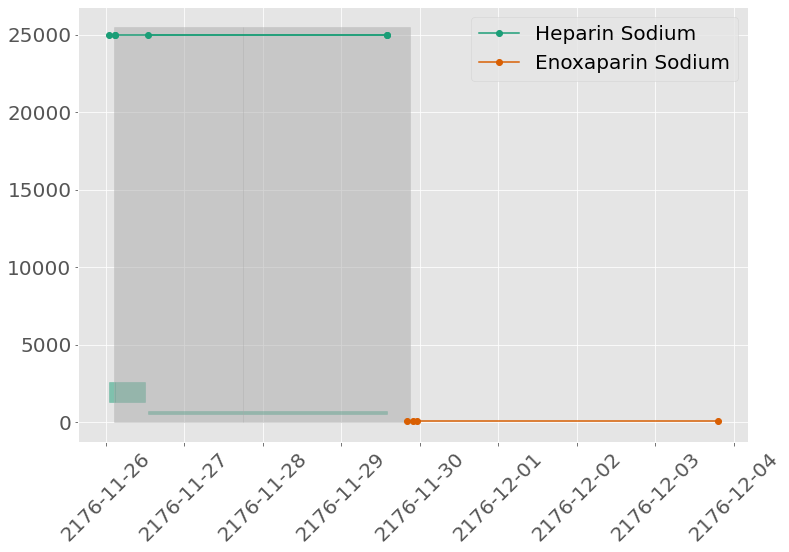

In [ ]:
meds = ['Heparin', 'Heparin Sodium', 'Enoxaparin Sodium']
colors = {
    'Heparin': '#1b9e77',
    'Heparin Sodium': '#1b9e77',
    'Enoxaparin Sodium': '#d95f02'
}
idx = pr['drug'].isin(meds)
df = pr.loc[idx].copy()

plt.figure(figsize=[12, 8])
for med in meds:
  color = colors[med]
  idx = df['drug'] == med
  n = 0
  for i, row in df.loc[idx].iterrows():
    if n > 0:
      # do not add to the legend if we have already plotted at least once
      med = '__no_legend__'

    xi = [row['starttime'], row['stoptime']]
    dose = row['dose_val_rx']
    if '-' in dose:
      # plot upper/lower ranges
      dose_lower, dose_upper = dose.split('-')
      dose_lower = int(dose_lower)
      dose_upper = int(dose_upper)
      plt.fill_between(xi, [dose_lower, dose_lower], [dose_upper, dose_upper], color=color, alpha=0.5)
    else:
      dose = pd.to_numeric(dose.replace(',', ''))
      plt.plot(xi, [dose, dose], 'o-', color=color, label=med)
    n += 1


# shade in their ICU stay
upper = 25500
for i, row in tr.iterrows():
  if row['careunit'] is None:
    continue
  if 'ICU' in row['careunit']:
    plt.fill_between([row['intime'], row['outtime']], [0, 0], [upper, upper], color='#ababab', alpha=0.5)


plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
idx = emar['medication'].isin(['Heparin', 'Enoxaparin Sodium'])
df_emar = emar.loc[idx].copy()

# dose due is in the "parent" of the emar detail group
# where parent_field_ordinal is null
# only 1 of these per emar_id
idx = emardet['parent_field_ordinal'].isnull()
cols = [
  'emar_id', 'administration_type', 'dose_due', 'dose_due_unit',
  'complete_dose_not_given', 'will_remainder_of_dose_be_given'
]
df_emar = df_emar.merge(emardet.loc[idx, cols], on='emar_id', how='left')
df_emar['dose_due'] = pd.to_numeric(df_emar['dose_due'])

# add in the actual dose administered
# since it can be across multiple formulary doses (e.g. multiple pills)
# we aggregate the detail table
# in heparin/enoxaparin case, we are probably aggregating over a single adm
# note that for heparin, since it's a continuous infusion, dose_given is 0/None
idx = emardet['parent_field_ordinal'].notnull()
cols = ['emar_id', 'dose_given', 'dose_given_unit', 'product_amount_given', 'product_unit']
em = emardet.loc[idx, cols].copy()

# re-cast columns - sometimes drugs have string doses
em['dose_given'] = pd.to_numeric(em['dose_given'], errors='coerce')
em['product_amount_given'] = pd.to_numeric(em['product_amount_given'], errors='coerce')

em = em.groupby('emar_id').agg(
  dose_given=pd.NamedAgg(column='dose_given', aggfunc='sum'),
  dose_given_unit=pd.NamedAgg(column='dose_given_unit', aggfunc='max'),
  product_amount_given=pd.NamedAgg(column='product_amount_given', aggfunc='sum'),
  product_unit=pd.NamedAgg(column='product_unit', aggfunc='max'),
)

df_emar = df_emar.merge(em, on='emar_id', how='left')
df_emar.sort_values(['charttime', 'emar_seq'], inplace=True)

# display a subset of the columns
cols = ['hadm_id', 'emar_id', 'pharmacy_id', 'charttime', 'medication',
        'administration_type', 'scheduletime', 'storetime',
        'dose_due', 'dose_due_unit', 'dose_given', 'dose_given_unit']
df_emar[cols].head(n=5)

,hadm_id,emar_id,pharmacy_id,charttime,medication,administration_type,scheduletime,storetime,dose_due,dose_due_unit,dose_given,dose_given_unit
0,27882036,10012853-138,76768838.0,2176-11-26 03:30:00,Heparin,Heparin IV Infusion,2176-11-26 03:30:00,2176-11-26 03:38:00,1150,units/hr,0.0,UNIT
1,27882036,10012853-141,79252552.0,2176-11-26 03:42:00,Heparin,Heparin IV Infusion,2176-11-26 03:42:00,2176-11-26 03:42:00,1150,units/hr,0.0,UNIT
2,27882036,10012853-143,76768838.0,2176-11-26 07:09:00,Heparin,Heparin IV Infusion,2176-11-26 07:09:00,2176-11-26 07:09:00,1150,units/hr,0.0,UNIT
3,27882036,10012853-152,76768838.0,2176-11-26 07:49:00,Heparin,Heparin IV Infusion,2176-11-26 07:49:00,2176-11-26 07:49:00,1150,units/hr,0.0,UNIT
4,27882036,10012853-153,76768838.0,2176-11-26 12:29:00,Heparin,Heparin IV Infusion,2176-11-26 12:29:00,2176-11-26 12:29:00,900,units/hr,0.0,UNIT


Above, we've combined detailed information about the eMAR administrations (primarily to get the dose given) with the main information about the administrations in the *emar* table.

We can see a lot of information here: when heparin was started, stopped, when dosing was confirmed, and so on. We also can see the `dose_due`. In this case, `dose_given` is 0, and this appears to happen as this is a continuous infusion rather than an individual dose.

Note that the `pharmacy_id` gives us a link to the associated record in the *pharmacy* table, which we can look up pretty easily:

In [ ]:
ph.loc[ph['pharmacy_id'].isin([76768838, 79252552]), ['hadm_id', 'pharmacy_id', 'starttime', 'stoptime', 'medication', 'proc_type', 'route', 'frequency']]

,hadm_id,pharmacy_id,starttime,stoptime,medication,proc_type,route,frequency
0,27882036,79252552,2176-11-26 01:00:00,2176-11-26 03:00:00,Heparin,IV Piggyback,IV,ASDIR
3,27882036,76768838,2176-11-26 03:00:00,2176-11-29 14:00:00,Heparin,IV Piggyback,IV,ASDIR


We can similarly find the orders in prescriptions. In the below example, we're highlighting how you can find drugs using the name of the drug, though note that a few of the `pharmacy_id` again match the administrations above.

In [ ]:
idx = pr['drug'].isin(['Heparin', 'Heparin Sodium'])
pr.loc[idx, ['subject_id', 'pharmacy_id', 'starttime', 'stoptime', 'drug', 'dose_val_rx']]

,subject_id,pharmacy_id,starttime,stoptime,drug,dose_val_rx
1,10012853,79252552,2176-11-26 01:00:00,2176-11-26 03:00:00,Heparin Sodium,"25,000"
2,10012853,48110147,2176-11-26 01:00:00,2176-11-26 03:00:00,Heparin,1300-2600
6,10012853,76768838,2176-11-26 03:00:00,2176-11-29 14:00:00,Heparin Sodium,"25,000"
7,10012853,43116382,2176-11-26 03:00:00,2176-11-26 12:00:00,Heparin,1300-2600
39,10012853,94608405,2176-11-26 13:00:00,2176-11-29 14:00:00,Heparin Sodium,"25,000"
40,10012853,76339453,2176-11-26 13:00:00,2176-11-29 14:00:00,Heparin,500-750


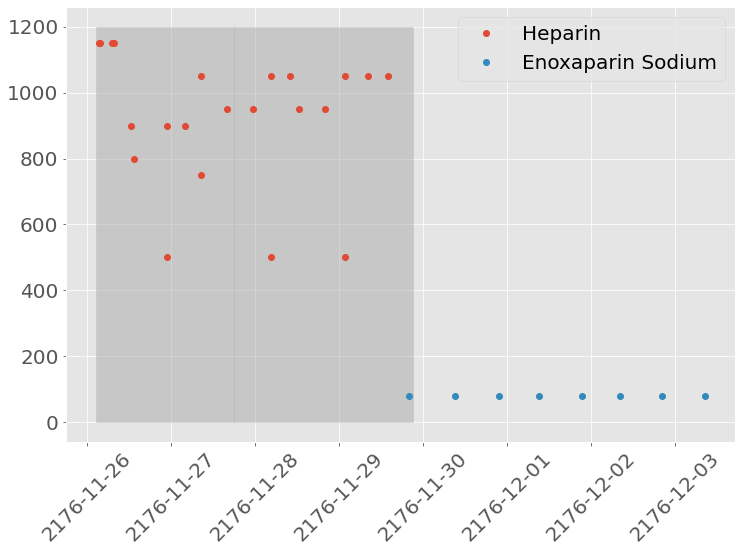

In [ ]:
plt.figure(figsize=[12, 8])
for med in df_emar['medication'].unique():
  idx = df_emar['medication'] == med
  plt.plot(df_emar.loc[idx, 'charttime'], df_emar.loc[idx, 'dose_due'], 'o', label=med)


# shade in their ICU stay
upper = 1200
for i, row in tr.iterrows():
  if row['careunit'] is None:
    continue
  if 'ICU' in row['careunit']:
    plt.fill_between([row['intime'], row['outtime']], [0, 0], [upper, upper], color='#ababab', alpha=0.5)


plt.legend()
plt.xticks(rotation=45)
plt.show()

Finally, we can combine the medication information with other information (e.g. labs). Often anticoagulants are titrated based on a coagulation factor in the blood, so let's plot these medications with those factors.

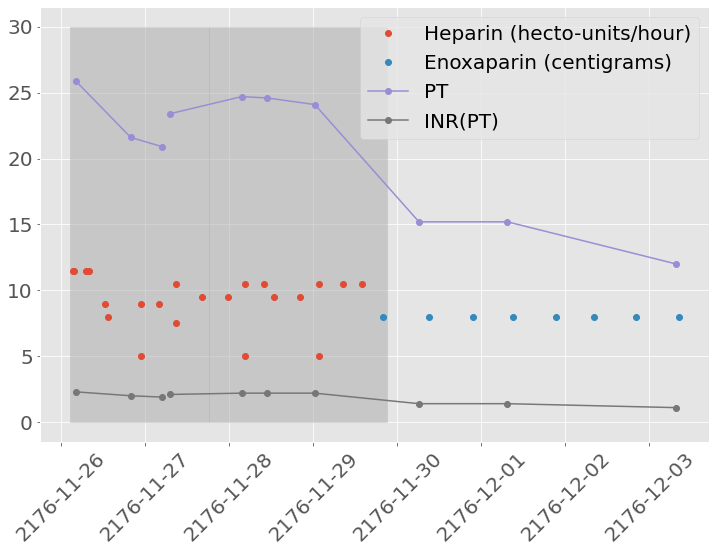

In [ ]:
plt.figure(figsize=[12, 8])
meds = {
    'Heparin': 'Heparin (hecto-units/hour)',
    'Enoxaparin Sodium': 'Enoxaparin (centigrams)',
}
for med, label in meds.items():
  idx = df_emar['medication'] == med
  if med == 'Heparin':
    multiplier = 0.01
  else:
    multiplier = 0.1
  plt.plot(df_emar.loc[idx, 'charttime'], df_emar.loc[idx, 'dose_due'] * multiplier, 'o', label=label)


# plot the lab factors
for label in ['PT', 'INR(PT)']:
  idx = lab['label'] == label
  plt.plot(lab.loc[idx, 'charttime'], lab.loc[idx, 'valuenum'], 'o-', label=label)

# shade in their ICU stay
upper = 30
for i, row in tr.iterrows():
  if row['careunit'] is None:
    continue
  if 'ICU' in row['careunit']:
    plt.fill_between([row['intime'], row['outtime']], [0, 0], [upper, upper], color='#ababab', alpha=0.5)

plt.legend()
plt.xticks(rotation=45)
plt.show()

**Note that heparin/enoxaparin administrations have special units**. Heparin is usually in units/hour, we've plotted hecto-units/hour (1/100 units). Similarly we've plotted centigrams rather than milligrams (1/10 mg).

Without knowing the reference ranges of the coagulation measures, it's hard to know whether this is OK! We can add those to the plot using the reference ranges from the lab table.



,label,ref_range_lower,ref_range_upper
22,INR(PT),0.9,1.1
31,PT,9.4,12.5


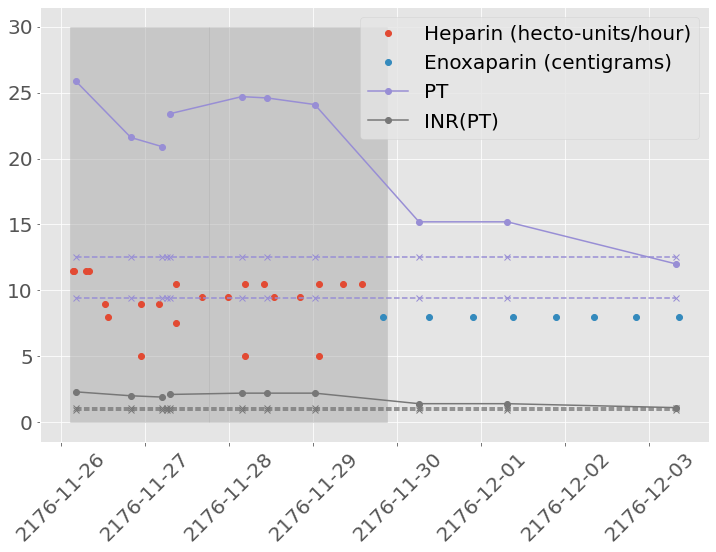

In [ ]:
plt.figure(figsize=[12, 8])
meds = {
    'Heparin': 'Heparin (hecto-units/hour)',
    'Enoxaparin Sodium': 'Enoxaparin (centigrams)',
}
for med, label in meds.items():
  idx = df_emar['medication'] == med
  if med == 'Heparin':
    multiplier = 0.01
  else:
    multiplier = 0.1
  plt.plot(df_emar.loc[idx, 'charttime'], df_emar.loc[idx, 'dose_due'] * multiplier, 'o', label=label)


# plot the lab factors
for label in ['PT', 'INR(PT)']:
  idx = lab['label'] == label
  # plot the lab itself
  p = plt.plot(lab.loc[idx, 'charttime'], lab.loc[idx, 'valuenum'], 'o-', label=label)

  # plot the lower/upper reference range
  plt.plot(lab.loc[idx, 'charttime'], lab.loc[idx, 'ref_range_lower'], 'x--', color=p[0].get_color(), label='__no_legend__')
  plt.plot(lab.loc[idx, 'charttime'], lab.loc[idx, 'ref_range_upper'], 'x--', color=p[0].get_color(), label='__no_legend__')

# print the reference ranges
idx = lab['label'].isin(['PT', 'INR(PT)'])
display(lab.loc[idx, ['label', 'ref_range_lower', 'ref_range_upper']].drop_duplicates())

# shade in their ICU stay
upper = 30
for i, row in tr.iterrows():
  if row['careunit'] is None:
    continue
  if 'ICU' in row['careunit']:
    plt.fill_between([row['intime'], row['outtime']], [0, 0], [upper, upper], color='#ababab', alpha=0.5)

plt.legend()
plt.xticks(rotation=45)
plt.show()

From this it's much clearer that this patient has very high levels of anticoagulation, and that her blood takes significantly longer to plot than the reference ranges. This may be due to a disease process or a therapeutic treatment for certain conditions (atrial fibrillation, etc). In this case, as the patient came in with a DVT, we can be fairly sure this is therapeutic anticoagulation.


### *d_hcpcs*, *hcpcsevents*, *d_icd_diagnoses*, *diagnoses_icd*, *d_icd_procedures*, *procedures_icd*, *drgcodes*

The billing code tables record information about diagnoses and procedures for which a patient was billed. They are often used as surrogates for the diseases or conditions a patient has, though caution is warranted as billed items do not perfectly account for all procedures and diseases present. For example, obesity is common in the ICU cohort as measured patient body mass index (over 30% of patients are obese), but rare if checked with the diagnostic billing code for obesity (~10%). We can look at the diagnosis table for this hospitalization to get an idea of how the billing tables work.

In [ ]:
query = f"""
SELECT dx.*, di.long_title
FROM `physionet-data.{dataset}_hosp.diagnoses_icd` dx
INNER JOIN `physionet-data.{dataset}_hosp.d_icd_diagnoses` di
  ON dx.icd_code = di.icd_code
WHERE hadm_id = {hadm_id}
ORDER BY dx.seq_num
"""
dx = run_query(query)
dx

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title
0,10012853,27882036,1,I82622,10,Acute embolism and thrombosis of deep veins of...
1,10012853,27882036,2,J9621,10,Acute and chronic respiratory failure with hyp...
2,10012853,27882036,3,I480,10,Paroxysmal atrial fibrillation
3,10012853,27882036,4,N319,10,"Neuromuscular dysfunction of bladder, unspecified"
4,10012853,27882036,5,J449,10,"Chronic obstructive pulmonary disease, unspeci..."
5,10012853,27882036,6,D472,10,Monoclonal gammopathy
6,10012853,27882036,7,J9622,10,Acute and chronic respiratory failure with hyp...
7,10012853,27882036,8,I129,10,Hypertensive chronic kidney disease with stage...
8,10012853,27882036,9,N183,10,"Chronic kidney disease, stage 3 (moderate)"
9,10012853,27882036,10,I739,10,"Peripheral vascular disease, unspecified"


Above we can see that there are many diagnoses for this visit (29!). The `seq_num` column provides an ordering for diagnoses. The order does have some meaning; the first diagnosis is usually considered "primary", but disease specific coding practices may impact this. In this case, we can see the patient was admitted for an acute thrombosis (`seq_num` = 1) with associated respiratory failure (`seq_num` = 2). Other conditions were likely chronic and occuring prior to their hospitalization (e.g. obstructive sleep apnea), while some diseases are certainly acute and localized to the hospital stay (i.e. the embolism).

In [ ]:
query = f"""
SELECT drg.*
FROM `physionet-data.{dataset}_hosp.drgcodes` drg
WHERE hadm_id = {hadm_id}
"""
drg = run_query(query)
drg

,subject_id,hadm_id,drg_type,drg_code,description,drg_severity,drg_mortality
0,10012853,27882036,HCFA,299,PERIPHERAL VASCULAR DISORDERS W MCC,NaN,NaN
1,10012853,27882036,APR,1973,Peripheral & Other Vascular Disorders,3.0,3.0
2,10012853,27882036,APR,1973,Peripheral & Other Vascular Disorders,3.0,3.0


In [ ]:
query = f"""
SELECT dx.*, di.long_title
FROM `physionet-data.{dataset}_hosp.procedures_icd` dx
INNER JOIN `physionet-data.{dataset}_hosp.d_icd_procedures` di
  ON dx.icd_code = di.icd_code
WHERE hadm_id = {hadm_id}
ORDER BY dx.seq_num
"""
proc = run_query(query)
print(proc.iloc[0, -1])
proc

Assistance with Respiratory Ventilation, Greater than 96 Consecutive Hours, Continuous Positive Airway Pressure


,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title
0,10012853,27882036,1,5A09557,10,"Assistance with Respiratory Ventilation, Great..."


Surprisingly there is only one procedure with the patient hospitalization - a ventilation event which lasted over 96 hours.

In [ ]:
query = f"""
SELECT h.*
FROM `physionet-data.{dataset}_hosp.hcpcsevents` h
WHERE hadm_id = {hadm_id}
"""
hcpcs = run_query(query)
hcpcs

,subject_id,hadm_id,hcpcs_cd,seq_num,short_description


And finally, there are no HCPCS associated data with this patient.

### *icu*

The *icu* dataset contains information primarily sourced from the MetaVision clinical information system (iMDSoft). MetaVision is used to document most measurements, treatments, and ongoing processes for a patient while they stay in the ICU. The *icu* dataset has an *icustays* table which defines individual patient stays in the ICU (based upon *transfers*), and the remaining events tables which contain patient data. The tables are in a "star" schema, where the *d_items* table defines concepts indexed by the `itemid` column, and the remaining tables contain patient data for each `itemid`. The tables in the *icu* dataset are:

* *icustays*
* *d_items*
* Events tables:
  * *chartevents*
  * *datetimeevents*
  * *inputevents*
  * *outputevents*
  * *procedureevents*

### *icustays*

In [ ]:
query = f"""
SELECT *
FROM `physionet-data.{dataset}_icu.icustays`
WHERE hadm_id = {hadm_id}
"""
ie = run_query(query)

# retain stay_id for later queries
stay_id = ie['stay_id'].values[0]

ie

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10012853,27882036,38821082,Trauma SICU (TSICU),Trauma SICU (TSICU),2176-11-26 02:34:49,2176-11-29 20:58:54,3.766725


For this patient's hospitalization, we have a single ICU stay of almost 4 days. The patient was admitted to the ICU at `intime` (2176-11-26 02:34:49) and was discharged from the ICU at `outtime` (2176-11-29 20:58:54). Note that unlike the *transfers* table, the *icustays* table has only one row for the patient's ICU stay. This reflects an underlying assumption of the table where consecutive physical stays in the ICU are merged into a single encounter.

ICU encounters are indexed by the `stay_id` column. This uniquely identifies this patient's ICU stay.

### *chartevents* and *d_items*

Rather than individual investigate each event table, it's easiest to understand *chartevents*, and subsequently contrast the other tables to it. *chartevents* is the largest of the data tables, and contains most information documented during a patient's stay.

In [ ]:
# Load admissions
query = f"""
SELECT *
FROM `physionet-data.{dataset}_icu.chartevents`
WHERE stay_id = {stay_id}
ORDER BY charttime, itemid
"""
ce = run_query(query)
print(ce.shape)
ce.head()

(4050, 10)


,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,10012853,27882036,38821082,2176-11-26 02:34:00,2176-11-26 02:37:00,220045,77,77.0,bpm,0
1,10012853,27882036,38821082,2176-11-26 02:34:00,2176-11-26 02:37:00,220210,14,14.0,insp/min,0
2,10012853,27882036,38821082,2176-11-26 02:34:00,2176-11-26 02:37:00,220277,94,94.0,%,0
3,10012853,27882036,38821082,2176-11-26 02:34:00,2176-11-26 02:37:00,226512,71,71.0,kg,0
4,10012853,27882036,38821082,2176-11-26 02:35:00,2176-11-26 02:35:00,220046,130,130.0,bpm,0


During the patient's four days in the ICU over 4,000 observations were documented, highlighting how heavily monitored patients are. The `subject_id`, `hadm_id`, and `stay_id` columns are patient, hospital, and ICU stay identifiers as we are famiiar with. `charttime` contains the time at which a measurement corresponds to, whereas `storetime` contains when the measurement was stored in the system. The `itemid` column stores an integer which uniquely identifies concepts such as heart rate, oxygen saturation, and so on. The `value` column stores the patient measurement made, and if it is numeric, the `valuenum` column will contain it cast to a numeric data type. The `valueuom` contains the unit of measurement associated with the value (if appropriate). Finally, the `warning` column indicates if staff added a warning to the value.

To get an idea of what type of data is present in chartevents, we can join this table to *d_items* to get the `label` for each itemid, and do a simple count of the number of rows.

In [ ]:
query = f"""
SELECT *
FROM `physionet-data.{dataset}_icu.d_items`
ORDER BY itemid
"""
di = run_query(query)

print('Our top 5 rows and their associated definitions.')

display(ce[['stay_id', 'charttime', 'itemid', 'value', 'valueuom']].head(n=4))

itemid = ce['itemid'].head(n=4).values
display(di.loc[di['itemid'].isin(itemid), ['itemid', 'label', 'category', 'linksto']].sort_values('itemid'))

ce.merge(di, on='itemid', how='inner')['label'].value_counts()[:30]

Our top 5 rows and their associated definitions.


,stay_id,charttime,itemid,value,valueuom
0,38821082,2176-11-26 02:34:00,220045,77,bpm
1,38821082,2176-11-26 02:34:00,220210,14,insp/min
2,38821082,2176-11-26 02:34:00,220277,94,%
3,38821082,2176-11-26 02:34:00,226512,71,kg


,itemid,label,category,linksto
1,220045,Heart Rate,Routine Vital Signs,chartevents
27,220210,Respiratory Rate,Respiratory,chartevents
35,220277,O2 saturation pulseoxymetry,Respiratory,chartevents
1734,226512,Admission Weight (Kg),General,chartevents


Safety Measures                                       166
Respiratory Rate                                       93
Ectopy Type 1                                          92
O2 saturation pulseoxymetry                            92
Heart Rate                                             92
Heart Rhythm                                           92
Non Invasive Blood Pressure systolic                   86
Non Invasive Blood Pressure diastolic                  86
Non Invasive Blood Pressure mean                       85
Altered Respiratory Status NCP - Interventions         70
Altered Respiratory Status NCP - Expected outcomes     50
Activity / Mobility (JH-HLM)                           45
Activity Tolerance                                     44
Assistance                                             43
Head of Bed                                            42
Position                                               41
Impaired Tissue Perfusion NCP - Expected outcomes      40
Turn          

We can see the most frequently documented item are the safety measures in place around the patient, followed by vital signs, measurements around activity, bed positioning, respiratory measures, an anti embolism device, and so on.
As vital signs are frequently documented, they provide a useful visualization of the data in the *chartevents* table. However, to find out which `itemid` values correspond to routinely measured vital signs, we must look for them in the *d_items* table.

In [ ]:
idx = di['category'] == 'Routine Vital Signs'
di.loc[idx]

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
1,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
4,220048,Heart Rhythm,Heart Rhythm,chartevents,Routine Vital Signs,None,Text,NaN,NaN
5,220050,Arterial Blood Pressure systolic,ABPs,chartevents,Routine Vital Signs,mmHg,Numeric,90.0,140.0
6,220051,Arterial Blood Pressure diastolic,ABPd,chartevents,Routine Vital Signs,mmHg,Numeric,60.0,90.0
7,220052,Arterial Blood Pressure mean,ABPm,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
23,220179,Non Invasive Blood Pressure systolic,NBPs,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
24,220180,Non Invasive Blood Pressure diastolic,NBPd,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
25,220181,Non Invasive Blood Pressure mean,NBPm,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
225,223761,Temperature Fahrenheit,Temperature F,chartevents,Routine Vital Signs,°F,Numeric,NaN,NaN
226,223762,Temperature Celsius,Temperature C,chartevents,Routine Vital Signs,°C,Numeric,NaN,NaN


We can see that there are quite a few columns in the *d_items* table. The `label` column provides a human interpretable description of the `itemid`, while `abbreviation` shows an abbreviated form. The `linksto` column indicates which table contains data associated with the `itemid` (each `itemid` is only ever present in one of the events tables). The remaining columns provide information about the concept: a high level category (`category`), the unit of measure (`unitname`), and the type of measurement (`param_type`, can be 'Text' for drop down items, 'Numeric' for numeric data, 'Date' for timestamp data, or 'Checkbox' for 0/1 data). Normal reference ranges are also provided in the `lownormalvalue` and `highnormalvalue` columns.

Scrolling through this list, we can identify five `itemid` for vital signs to plot:

* 220210 - Respiratory Rate
* 220045 - Heart Rate
* 220179 - Non Invasive Blood Pressure - systolic
* 220180 - Non Invasive Blood Pressure - diastolic
* 220181 - Non Invasive Blood Pressure - mean
* 223762 - Temperature Celsius

We can now plot the vital signs for our patient by selecting only the rows corresponding to each one of these `itemid` values in turn.

N.B. We do not include 220052 (Arterial Blood Pressure mean) as the patient never has it measured (i.e. they never had an indwelling arterial catheter), though it would certainly be a useful measure for other patients.

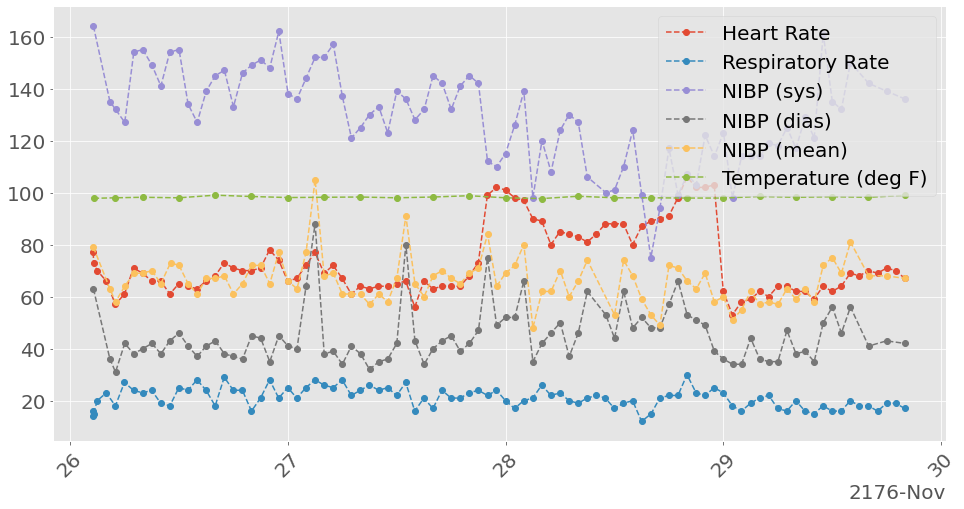

In [ ]:
plt.figure(figsize=[16, 8])

chart_labels = {
  220045: 'Heart Rate',
  220210: 'Respiratory Rate',
  220179: 'NIBP (sys)',
  220180: 'NIBP (dias)',
  220181: 'NIBP (mean)',
  223761: 'Temperature (deg F)'
}
for itemid, label in chart_labels.items():
  # charted data from the ICU
  idx = ce['itemid'] == itemid
  dff = ce.loc[idx].sort_values('charttime')
  p = plt.plot(dff['charttime'], dff['valuenum'], 'o--', label=label)

plt.legend(loc='upper right')
plt.xticks(rotation=45)

# concise dates on the x-axis
ax = plt.gca()
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# plt.xlim(['2110-09-06 18:00:00', '2110-09-08 18:00:00'])
plt.show()

Interestingly we can see a sudden increase in the patient's heart rate just before midnight on the 28th. There are a few possible causes, and we could plot associated data to try to figure it out! An obvious first check is the patient's heart rhythm.

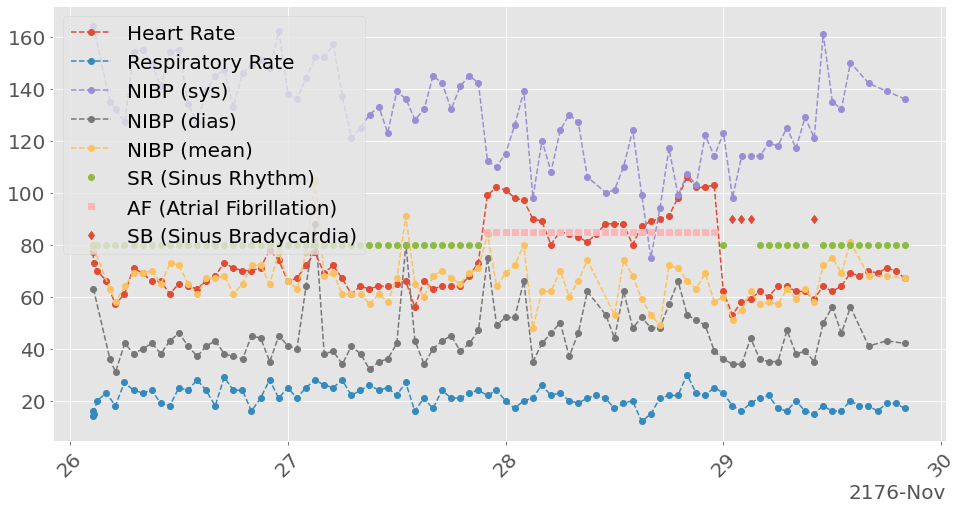

In [ ]:
plt.figure(figsize=[16, 8])

chart_labels = {
  220045: 'Heart Rate',
  220210: 'Respiratory Rate',
  220179: 'NIBP (sys)',
  220180: 'NIBP (dias)',
  220181: 'NIBP (mean)'
}
for itemid, label in chart_labels.items():
  # charted data from the ICU
  idx = ce['itemid'] == itemid
  dff = ce.loc[idx].sort_values('charttime')
  p = plt.plot(dff['charttime'], dff['valuenum'], 'o--', label=label)

markers = ['o', 's', 'd', '^']
rhythms = ce.loc[ce['itemid'] == 220048, 'value'].unique()
for i, rhythm in enumerate(rhythms):
  idx = (ce['itemid'] == 220048) & (ce['value'] == rhythm)
  plt.plot(ce.loc[idx, 'charttime'], np.ones(idx.sum())*80 + i*5, markers[i], label=rhythm)

plt.legend(loc='upper left')
plt.xticks(rotation=45)

# concise dates on the x-axis
ax = plt.gca()
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# plt.xlim(['2110-09-06 18:00:00', '2110-09-08 18:00:00'])
plt.show()

This makes it quite clear - the patient has atrial fibrillation charted at 22:00:00 which is around the time the heart rate increases. You may have also noted that paroxysmal atrial fibrillation was one of the diagnoses billed for in the *diagnoses_icd* table earlier.

### Other events tables

With our new understanding of *chartevents*, it's fairly easy to understand the other events tables.

* *datetimeevents* - This table is similar to *chartevents*, but the `value` in this case is a date shifted date which is consistent with the patient's deidentified timeline
* *outputevents* - Contains outputs from the patient: urine output volume, fluid output from drains, stool, and so on.
* *inputevents* - Contains inputs given to the patient either orally or via another route, with intravenous being common. Notably this table does not have `charttime`: each row has a `starttime` and an `endtime`, and inputs are durations rather than instantaneous events.
* *procedureevents* - Similar to *inputevents*, but for processes which are not patient inputs (mechanical ventilation, dialysis, and so on).

Let's look at *inputevents* since it contains useful information about patient administrations and has a slightly different form than *chartevents*.

In [ ]:
# Load admissions
query = f"""
SELECT *
FROM `physionet-data.{dataset}_icu.datetimeevents`
ORDER BY charttime
LIMIT 5
"""
inp = run_query(query)
print(inp.shape)
inp.head()

(5, 9)


,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valueuom,warning
0,10001725,25563031,31374978,2110-04-11 16:02:00,2110-04-11 16:03:00,225754,2110-04-11 16:02:00,Date,0
1,10001725,25563031,31374978,2110-04-11 16:35:00,2110-04-11 16:36:00,225754,2110-04-11 16:36:00,Date,0
2,10001725,25563031,31374978,2110-04-11 20:39:00,2110-04-11 20:39:00,225754,2110-04-11 00:00:00,Date,0
3,10001725,25563031,31374978,2110-04-12 02:00:00,2110-04-12 04:57:00,225754,2110-04-11 00:00:00,Date,0
4,10001725,25563031,31374978,2110-04-12 08:05:00,2110-04-12 10:05:00,225754,2110-04-11 00:00:00,Date,0


In [ ]:
# Load admissions
query = f"""
SELECT *
FROM `physionet-data.{dataset}_icu.inputevents`
WHERE stay_id = {stay_id}
ORDER BY starttime, itemid
"""
inp = run_query(query)
print(inp.shape)
inp.head()

(51, 26)


,subject_id,hadm_id,stay_id,starttime,endtime,storetime,itemid,amount,amountuom,rate,rateuom,orderid,linkorderid,ordercategoryname,secondaryordercategoryname,ordercomponenttypedescription,ordercategorydescription,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,cancelreason,statusdescription,originalamount,originalrate
0,10012853,27882036,38821082,2176-11-26 02:37:00,2176-11-26 12:27:00,2176-11-26 02:38:00,220949,113.113495,ml,11.503067,mL/hour,1770967,1770967,01-Drips,02-Fluids (Crystalloids),Mixed solution,Continuous Med,71.0,250.0,ml,0,0,0,Paused,250.000000,11.5031
1,10012853,27882036,38821082,2176-11-26 02:37:00,2176-11-26 12:27:00,2176-11-26 02:38:00,225152,11311.349983,units,1150.306763,units/hour,1770967,1770967,01-Drips,02-Fluids (Crystalloids),Main order parameter,Continuous Med,71.0,250.0,ml,0,0,0,Paused,25000.000000,1150.0000
2,10012853,27882036,38821082,2176-11-26 03:43:00,2176-11-26 18:01:00,2176-11-26 03:44:00,225828,714.999983,ml,50.000000,mL/hour,6811790,6811790,02-Fluids (Crystalloids),Additive (Crystalloid),Main order parameter,Continuous IV,71.0,1000.0,ml,0,0,0,Paused,1000.000000,50.0000
3,10012853,27882036,38821082,2176-11-26 07:53:00,2176-11-26 07:54:00,2176-11-26 07:53:00,226452,60.000000,ml,NaN,None,7659886,7659886,14-Oral/Gastric Intake,None,Main order parameter,Bolus,71.0,60.0,ml,0,0,0,FinishedRunning,60.000000,60.0000
4,10012853,27882036,38821082,2176-11-26 13:33:00,2176-11-26 13:38:00,2176-11-26 13:33:00,220949,0.958589,ml,11.503067,mL/hour,444439,1770967,01-Drips,02-Fluids (Crystalloids),Mixed solution,Continuous Med,71.0,250.0,ml,0,0,0,ChangeDose/Rate,136.916672,11.5031


As mentioned before, we see we have a `starttime` and an `endtime` for each patient. Note also the large number of extra columns describing the input given including the type, the patient's weight (many medications are dosed by weight), the original amount in the container which held the medication (e.g. the volume of the IV bag), and so on.

Let's look for medications started after 20:00:00 on 2173-03-31.

In [ ]:
df = inp.merge(di[['itemid', 'label']], on='itemid', how='inner')
idx = df['starttime'] >= '2173-03-31 20:00:00'
cols = ['stay_id', 'starttime', 'endtime', 'itemid', 'label', 'amount', 'amountuom', 'rate', 'rateuom']
df.loc[idx, cols].sort_values(['starttime', 'label'])

,stay_id,starttime,endtime,itemid,label,amount,amountuom,rate,rateuom
0,38821082,2176-11-26 02:37:00,2176-11-26 12:27:00,220949,Dextrose 5%,113.113495,ml,11.503067,mL/hour
12,38821082,2176-11-26 02:37:00,2176-11-26 12:27:00,225152,Heparin Sodium,11311.349983,units,1150.306763,units/hour
28,38821082,2176-11-26 03:43:00,2176-11-26 18:01:00,225828,LR,714.999983,ml,50.000000,mL/hour
34,38821082,2176-11-26 07:53:00,2176-11-26 07:54:00,226452,PO Intake,60.000000,ml,NaN,None
1,38821082,2176-11-26 13:33:00,2176-11-26 13:38:00,220949,Dextrose 5%,0.958589,ml,11.503067,mL/hour
13,38821082,2176-11-26 13:33:00,2176-11-26 13:38:00,225152,Heparin Sodium,95.858898,units,1150.306763,units/hour
2,38821082,2176-11-26 13:38:00,2176-11-26 22:46:00,220949,Dextrose 5%,73.115714,ml,8.005370,mL/hour
14,38821082,2176-11-26 13:38:00,2176-11-26 22:46:00,225152,Heparin Sodium,7311.571220,units,800.536987,units/hour
29,38821082,2176-11-26 19:01:00,2176-11-26 22:35:00,225828,LR,178.333329,ml,50.000000,mL/hour
30,38821082,2176-11-26 22:35:00,2176-11-26 23:56:00,225828,LR,101.266994,ml,75.012589,mL/hour


Note the administration of magnesium - a common treatment for atrial fibrillation. We can plot the administration of the treatment over time combined with the vital signs from earlier to visualize how the timing fits.

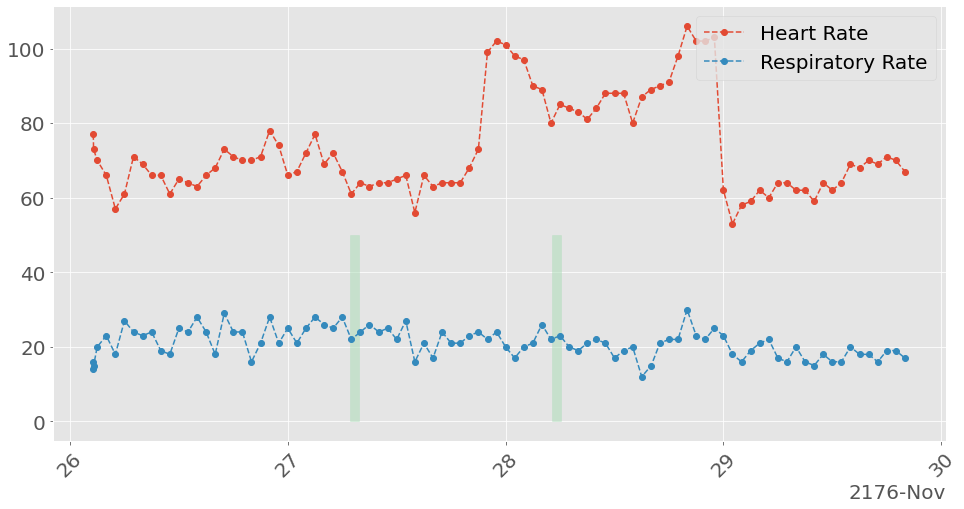

In [ ]:
plt.figure(figsize=[16, 8])

chart_labels = {
  220045: 'Heart Rate',
  220210: 'Respiratory Rate'
}
for itemid, label in chart_labels.items():
  # charted data from the ICU
  idx = ce['itemid'] == itemid
  dff = ce.loc[idx].sort_values('charttime')
  p = plt.plot(dff['charttime'], dff['valuenum'], 'o--', label=label)


inp_labels = {
  227523: 'Magnesium'
}
for itemid, label in inp_labels.items():
  # charted data from the ICU
  idx = inp['itemid'] == itemid
  dff = inp.loc[idx].sort_values('starttime')
  for i, row in dff.iterrows():
    amount = pd.to_numeric(row['amount'])
    plt.fill_between([row['starttime'], row['endtime']], [0, 0], [amount, amount], color='#a8ddb5', alpha=0.5)

plt.legend(loc='upper right')
plt.xticks(rotation=45)

# concise dates on the x-axis
ax = plt.gca()
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# plt.xlim(['2110-09-06 18:00:00', '2110-09-08 18:00:00'])
plt.show()


From this, it's hard to conclude whether this is just magnesium supplementation or a treatment for AF - but it is certainly interesting!

You may have also noted that we now have a few different sources of medication information for a patient while they are in the ICU. If we go back to our plots regarding heparin, we can compare the in ICU documentation (*inputevents*) with the hospital level documentation (*emar* and *prescriptions*).

Note that the following code is quite complex! At a high level, we are:

* looking for `itemid` associated with heparin administration in *inputevents* (usually there will only be one `itemid` for a drug)
* separating bolus administrations of this drug (rate is NaN, while amount is non-zero) from the continuous administrations, primarily for visualization purposes
  * if you want the total amount of drug received, you could easily sum across the amount column
* looking for `medication` associated with heparin administration in *emar*
  * again, we separate out bolus administrations from continuous inputs.
  * it's not obvious from the code, but the *emar* table has a number of columns which further describe the administration (e.g. the unit of measure for these are "units" or "units/hour")
* finally, we search for `drug` names for heparin in the *prescriptions* table
  * many of the prescriptions are ranges (1300-2600 units/hour), so the plot is a shaded box with the lower and upper prescribed dose
  * some prescriptions are for large IV mixes of 25,000 units - plot these at 2500 to help the visualization

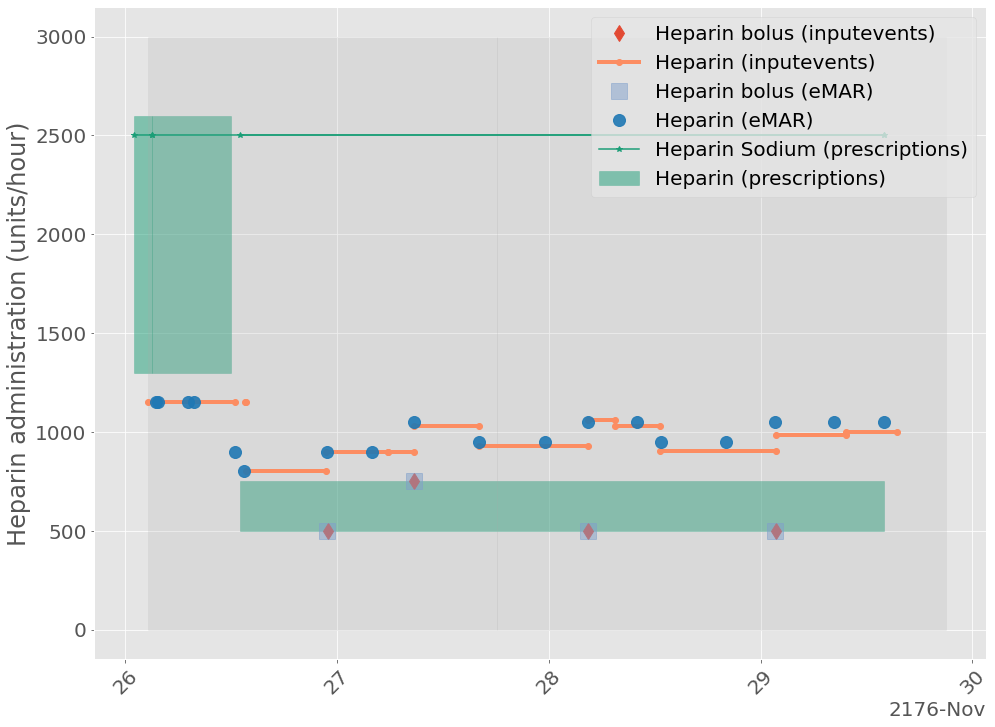

In [ ]:
plt.figure(figsize=[16, 12])

# ICU documentation (inputevents) of heparin administration
inp_labels = {
  225152: 'Heparin (inputevents)'
}

for itemid, label in inp_labels.items():
  idx = inp['itemid'] == itemid
  dff = inp.loc[idx].sort_values('starttime')
  # first, plot bolus heparin
  idx = dff['rate'].isnull()
  plt.plot(dff.loc[idx, 'starttime'], dff.loc[idx, 'amount'], 'd', markersize=12, label='Heparin bolus (inputevents)')

  for i, row in dff.iterrows():
    rate = pd.to_numeric(row['rate'])
    plt.plot([row['starttime'], row['endtime']], [rate, rate], 'o-', linewidth=4, color='#fc8d62', label=label)
    # disable legend plotting in future rows
    label = '__no_legend__'
    # plt.fill_between([row['starttime'], row['endtime']], [0, 0], [rate, rate], color='#fc8d62', alpha=0.8)

# eMAR documentation of heparin
med = 'Heparin'
idx_med = (df_emar['medication'] == med)
# first, plot bolus separately
idx = idx_med & (df_emar['administration_type'] == 'Heparin IV Bolus')
plt.plot(df_emar.loc[idx, 'charttime'], df_emar.loc[idx, 'dose_due'], 's', color='#80a0cb', markersize=16, alpha=0.5, label='Heparin bolus (eMAR)')

idx = idx_med & (df_emar['administration_type'] != 'Heparin IV Bolus')
plt.plot(df_emar.loc[idx, 'charttime'], df_emar.loc[idx, 'dose_due'], 'o', color='#1f78b4', markersize=12, alpha=0.9, label='Heparin (eMAR)')

# prescriptions documentation of heparin
meds = ['Heparin', 'Heparin Sodium']
colors = {
    'Heparin': '#1b9e77',
    'Heparin Sodium': '#1b9e77',
}
idx = pr['drug'].isin(meds)
df = pr.loc[idx].copy()

for med in meds:
  label = med + ' (prescriptions)'
  color = colors[med]
  idx = df['drug'] == med
  n = 0
  for i, row in df.loc[idx].iterrows():
    if n > 0:
      # do not add to the legend if we have already plotted at least once
      med = '__no_legend__'

    xi = [row['starttime'], row['stoptime']]
    dose = row['dose_val_rx']
    if '-' in dose:
      # plot upper/lower ranges
      dose_lower, dose_upper = dose.split('-')
      dose_lower = int(dose_lower)
      dose_upper = int(dose_upper)
      plt.fill_between(xi, [dose_lower, dose_lower], [dose_upper, dose_upper], color=color, alpha=0.5, label=label)
    else:
      dose = pd.to_numeric(dose.replace(',', ''))
      dose = dose / 10
      plt.plot(xi, [dose, dose], '*-', color=color, label=label)
    label = '__no_legend__'

    n += 1


# shade in their ICU stay
upper = 3000
for i, row in tr.iterrows():
  if row['careunit'] is None:
    continue
  if 'ICU' in row['careunit']:
    plt.fill_between([row['intime'], row['outtime']], [0, 0], [upper, upper], color='#ababab', alpha=0.2)

plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.ylabel('Heparin administration (units/hour)')

# concise dates on the x-axis
ax = plt.gca()
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.show()

**Note in the above the Heparin Sodium (prescriptions) are 25,000 units, downscaled by a factor of 10 for clarity.**

This plot highlights how useful administration data is. Prescription information describes the intention to treat, while administration describes the actual treatment given. This is very common in MIMIC-IV, particularly for medications which are titrated based on physiology. Note also the relatively good concordance between the manually documented ICU data in *inputevents* and the barcode scanned infusion administration information from *emar*.

## That's MIMIC-IV!

With the final comparison of the ICU and hospital level medication administration data, you'll now have a pretty good idea of the type information in MIMIC-IV.

But we're not done yet! One of the most interesting aspects of MIMIC-IV is that it uses the same patient identifiers as the recently published MIMIC-CXR database. Of course this is intentional to allow linking the to datasets!

## Chest x-rays for this patient

The `mimic_cxr` schema does not contain any of the data for MIMIC-CXR. Instead, it provides a useful mapping between the DICOM filenames and the patient anonymous identifiers.

The tables in `mimic_cxr` are:

* *study_list* - `subject_id`, `study_id`, `path`
  * Contains the relative path to individual radiology reports. Each radiology report is represented by a unique `study_id`. `study_id` is unique in this table (each row has a distinct `study_id`).
* *record_list* - `subject_id`, `study_id`, `dicom_id`, `path`
  * Contains the relative path to individual DICOMs. Each DICOM (represented by `dicom_id`) stores a chest x-ray related to a single radiographic study (represented by `study_id`). `dicom_id` is unique in this table (each row has a distinct `dicom_id`).
* *dicom_metadata_string* - `dicom`, ... (many columns corresponding to DICOM meta-data fields).

In order to access the `mimic_cxr` schema, you must request it via [the project page on PhysioNet](https://physionet.org/content/mimic-cxr/).

In [ ]:
query = f"""
select
  subject_id, study_id, path
from `physionet-data.mimic_cxr.study_list`
where subject_id = {subject_id}
ORDER BY study_id
"""
cxr_studies = run_query(query)
display(cxr_studies)

,subject_id,study_id,path
0,10012853,50200959,files/p10/p10012853/s50200959.txt
1,10012853,53243235,files/p10/p10012853/s53243235.txt
2,10012853,58181999,files/p10/p10012853/s58181999.txt
3,10012853,58569460,files/p10/p10012853/s58569460.txt


From the above, we can see that this subject had 4 distinct radiology studies which corresponded to chest x-rays. We do not know the order of these studies, or when they were performed, as the `study_id` is a random integer.

We can look for the unique DICOMs associated with this patient as well.

In [ ]:
query = f"""
select
  subject_id, study_id, dicom_id, path
from `physionet-data.mimic_cxr.record_list`
where subject_id = {subject_id}
ORDER BY study_id, dicom_id
"""
cxr_records = run_query(query)
display(cxr_records)

,subject_id,study_id,dicom_id,path
0,10012853,50200959,4736face-6f5f0e13-4b8bac9f-49661d81-a988229c,files/p10/p10012853/s50200959/4736face-6f5f0e1...
1,10012853,50200959,683930ea-a24d96eb-f0ef3736-3906153d-0ac7d866,files/p10/p10012853/s50200959/683930ea-a24d96e...
2,10012853,53243235,f6a37fec-15ac1f40-bf0526fc-39db0719-2b908d7a,files/p10/p10012853/s53243235/f6a37fec-15ac1f4...
3,10012853,58181999,aac02704-c647b84c-58d5df12-c9857852-e1536bba,files/p10/p10012853/s58181999/aac02704-c647b84...
4,10012853,58569460,7dcc1738-1674a7a7-42bb1860-d1551597-33f6de53,files/p10/p10012853/s58569460/7dcc1738-1674a7a...
5,10012853,58569460,da11ee9c-deaeb30c-7017c575-d04ac857-bf990bc1,files/p10/p10012853/s58569460/da11ee9c-deaeb30...


We now have six rows. This occurs because we often have more than one image associated with a single radiology study. This is common in chest x-rays, where a frontal view and a side view are standard. The frontal view can be "PA", standing for posterior-anterior (the image is a projection of the patient facing *away* from the scanner), or "AP" for anterior-posterior (the image is a projection of the patient facing *toward* the scanner). This has a bigger impact on the image than you might think initially, due to the physics of x-ray scanning

![AP vs PA chest x-ray.](https://github.com/MIT-LCP/mimic-cxr/raw/master/website/static/img/ap_vs_pa_opt.jpg)

As you can see, an AP image would result in a larger shadow of the heart on the x-ray scanner when compared to a PA scan. As a result, the orientation of the patient is important in correctly determining the size of the heart (and this is just the most obvious difference!).

Happily, the DICOM header provides information about the patient's orientation, and we have loaded most of the information in the DICOM header into a table on BigQuery. There are *many* columns in this table, but we can subselect the ones relevant for orientation.


In [ ]:
query = f"""
SELECT
  dicom, StudyID, PatientID, StudyDate, StudyTime, BodyPartExamined, ViewPosition, `Rows`, Columns, BurnedInAnnotation
from `physionet-data.mimic_cxr.dicom_metadata_string`
where PatientID = '{subject_id}'
ORDER BY 4, 5
"""
cxr_metadata = run_query(query)
display(cxr_metadata)

,dicom,StudyID,PatientID,StudyDate,StudyTime,BodyPartExamined,ViewPosition,Rows,Columns,BurnedInAnnotation
0,f6a37fec-15ac1f40-bf0526fc-39db0719-2b908d7a,53243235,10012853,21750405,062844.703,PORT CHEST,AP,2544,3056,YES
1,aac02704-c647b84c-58d5df12-c9857852-e1536bba,58181999,10012853,21750407,131841.031,CHEST,AP,3050,2539,YES
2,da11ee9c-deaeb30c-7017c575-d04ac857-bf990bc1,58569460,10012853,21760606,144043.421,CHEST,LATERAL,3056,2544,NO
3,7dcc1738-1674a7a7-42bb1860-d1551597-33f6de53,58569460,10012853,21760606,144043.421,CHEST,PA,3056,2544,NO
4,4736face-6f5f0e13-4b8bac9f-49661d81-a988229c,50200959,10012853,21761128,150953.187,CHEST,AP,3050,2539,YES
5,683930ea-a24d96eb-f0ef3736-3906153d-0ac7d866,50200959,10012853,21761128,150953.187,CHEST,AP,3050,2539,YES


Note the slight changes in schema, as this table uses DICOM standard field names. We can see that these are all chest x-rays (`BodyPartExamined`), and one is explicitly noted as a portable chest x-ray ("PORT CHEST"). The view position is AP for most images, though one is a lateral x-ray (all side profiles for chest x-rays have the left side of the patient next to the image receptor, so "LEFT LATERAL" and "LATERAL" are synonymous).

Note that we have x-rays from before their ICU admission (2176-11-28), as the patient visited the emergency room (which we saw in the *transfers* table earlier). We'll focus on their x-rays from the same date as their ICU admission.

We'll now subselect to the studies performed on 2176-11-28.

In [ ]:
idx = cxr_metadata['StudyDate'] == '21761128'
cxr_metadata = cxr_metadata.loc[idx]

cxr_records = cxr_records.merge(cxr_metadata, left_on='dicom_id', right_on='dicom', how='inner')
display(cxr_records)

,subject_id,study_id,dicom_id,path,dicom,StudyID,PatientID,StudyDate,StudyTime,BodyPartExamined,ViewPosition,Rows,Columns,BurnedInAnnotation
0,10012853,50200959,4736face-6f5f0e13-4b8bac9f-49661d81-a988229c,files/p10/p10012853/s50200959/4736face-6f5f0e1...,4736face-6f5f0e13-4b8bac9f-49661d81-a988229c,50200959,10012853,21761128,150953.187,CHEST,AP,3050,2539,YES
1,10012853,50200959,683930ea-a24d96eb-f0ef3736-3906153d-0ac7d866,files/p10/p10012853/s50200959/683930ea-a24d96e...,683930ea-a24d96eb-f0ef3736-3906153d-0ac7d866,50200959,10012853,21761128,150953.187,CHEST,AP,3050,2539,YES


We will also subselect the studies in the `cxr_studies` dataframe.

In [ ]:
cxr_studies = cxr_studies.loc[cxr_studies['study_id'].isin(cxr_records['study_id'])]
display(cxr_studies)

,subject_id,study_id,path
0,10012853,50200959,files/p10/p10012853/s50200959.txt


As we can see above, there was a single x-ray performed. We can use the relative pathname provided in the `path` column in combination with the Google Cloud Storage location of the data to load individual reports/images. This requires your PhysioNet account to be linked to your Google account, and requires you to specifically request access to MIMIC-CXR on Google Cloud via the [MIMIC-CXR PhysioNet page](https://physionet.org/content/mimic-cxr/).

In [ ]:
import os

cxr_location = 'gs://mimic-cxr-2.0.0.physionet.org/'

# print out the studies
for i, cxr_study in cxr_studies.iterrows():
  # load in the text
  path = cxr_study['path']
  study_id = cxr_study["study_id"]

  # the filename is the study_id with .txt extension
  # e.g. s########.txt
  fn = f's{study_id}.txt'

  # download the report if it hasn't been downloaded yet
  if not os.path.exists(fn):
    !gsutil cp {cxr_location}{path} ./

  with open(fn, 'r') as fp:
    txt = ''.join(fp.readlines())

  print(f'\n\n{"="*35} {study_id} {"="*35}\n')
  print(txt)

Copying gs://mimic-cxr-2.0.0.physionet.org/files/p10/p10012853/s50200959.txt...
/ [1 files][  1.2 KiB/  1.2 KiB]                                                
Operation completed over 1 objects/1.2 KiB.                                      


=================================== 50200959 ===================================

                                 FINAL REPORT
 EXAMINATION:  Chest radiograph
 
 INDICATION:  ___ year old woman with large goiter and hypercapnic acute on
 chronic respiratory failure. Please assess for diaphgramatic elevation or
 other intraparenchymal abnormality.  // assess diaphgrams
 
 TECHNIQUE:  Portable AP chest.
 
 COMPARISON:  Fractures radiographs of ___, ___, ___
 
 FINDINGS: 
 
 Since ___, moderate pulmonary congestion and mild interstitial edema is
 increased, moderate right pleural effusion is new, and moderate left basilar
 opacities are seen, likely representing atelectasis.  Moderate cardiomegaly is
 increased.  No pneumothorax.   Large goiter di

This gives us a fairly good idea of why the x-ray was performed. The patient was hypercapnic and they were assessing for some kind of abnormality which might explain the symptom. We can use a similar method to look at the chest x-ray itself!

In [ ]:
!pip install pydicom
import pydicom

     |████████████████████████████████| 35.5MB 1.2MB/s 


Copying gs://mimic-cxr-2.0.0.physionet.org/files/p10/p10012853/s50200959/4736face-6f5f0e13-4b8bac9f-49661d81-a988229c.dcm...
/ [1 files][ 14.8 MiB/ 14.8 MiB]                                                
Operation completed over 1 objects/14.8 MiB.                                     
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.94660658688960426830196019104902946177
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 2.25.55362949469033348352269585565668676650
(0002, 0013) Implementation Version Name         SH: 'MIMIC-CXR v2.0.0'
-------------------------------------------------
(0008, 0005) Specific Character Set          

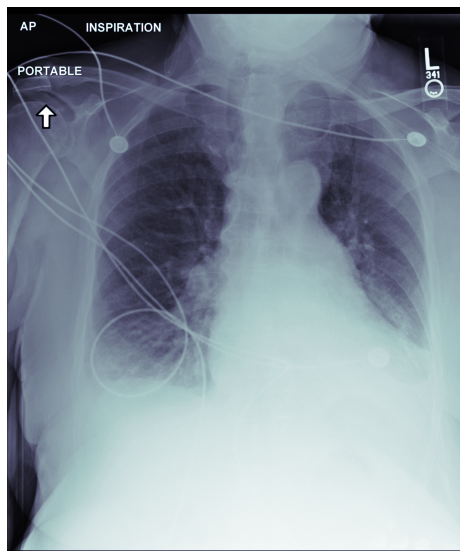

Copying gs://mimic-cxr-2.0.0.physionet.org/files/p10/p10012853/s50200959/683930ea-a24d96eb-f0ef3736-3906153d-0ac7d866.dcm...
/ [1 files][ 14.8 MiB/ 14.8 MiB]                                                
Operation completed over 1 objects/14.8 MiB.                                     
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.138536664627848808925277600384501028157
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 2.25.55362949469033348352269585565668676650
(0002, 0013) Implementation Version Name         SH: 'MIMIC-CXR v2.0.0'
-------------------------------------------------
(0008, 0005) Specific Character Set         

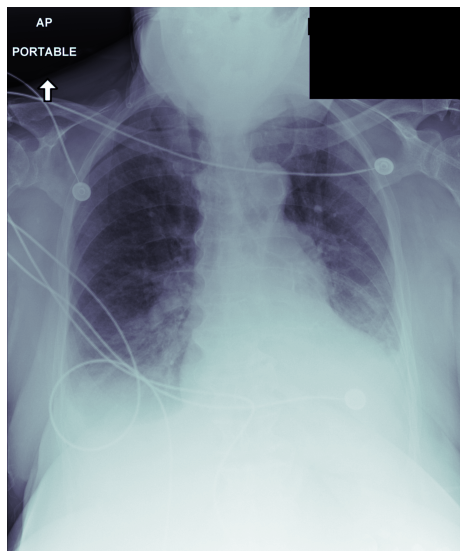

In [ ]:
# first DICOM study
for i, row in cxr_records.iterrows():
  dicom_id = row['dicom_id']
  dicom_path = row['path']
  fn = f'{dicom_id}.dcm'

  # download the image if it hasn't been downloaded yet
  if not os.path.exists(fn):
    # the DICOM is located at: {cxr_location}{path}
    # this is of the form:
    # gs://<bucket_name>/p10/p1######/s5#######/<dicom_id>.dcm
    # where p1###### is the patient identifier
    # and s5####### is the study identifier
    path = row['path']
    !gsutil cp {cxr_location}{path} ./

  with open(fn, 'rb') as fp:
    plan = pydicom.dcmread(fp)

  # print the DICOM plan - this is *long*!
  print(plan)

  # plot the image
  plt.figure(figsize=[16,10])
  plt.imshow(plan.pixel_array)
  plt.grid(False)
  plt.axis('off')
  # set colormap to bone
  plt.bone()
  plt.show()

For convenience, the MIMIC-CXR-JPG dataset contains all images in the MIMIC-CXR dataset preprocessed and converted to JPG. We can load these images as well. As JPG is a compressed format, the files are much smaller, though at a loss of resolution.

Copying gs://mimic-cxr-jpg-2.0.0.physionet.org/files/p10/p10012853/s50200959/4736face-6f5f0e13-4b8bac9f-49661d81-a988229c.jpg...
/ [1 files][  1.5 MiB/  1.5 MiB]                                                
Operation completed over 1 objects/1.5 MiB.                                      
4736face-6f5f0e13-4b8bac9f-49661d81-a988229c.jpg


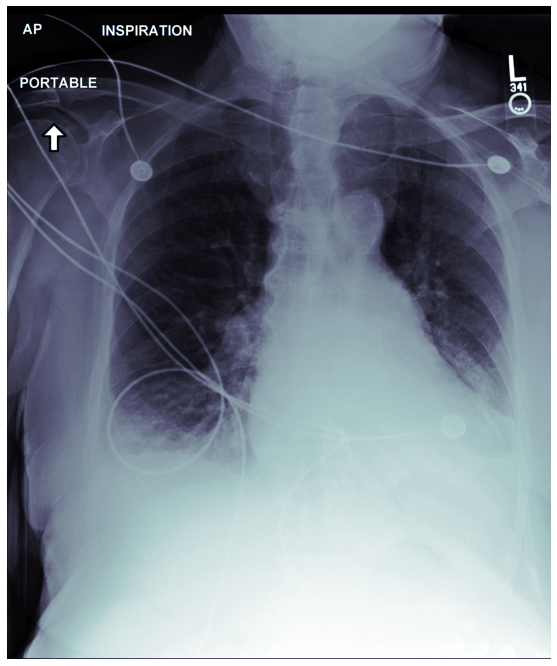

Copying gs://mimic-cxr-jpg-2.0.0.physionet.org/files/p10/p10012853/s50200959/683930ea-a24d96eb-f0ef3736-3906153d-0ac7d866.jpg...
/ [1 files][  1.5 MiB/  1.5 MiB]                                                
Operation completed over 1 objects/1.5 MiB.                                      
683930ea-a24d96eb-f0ef3736-3906153d-0ac7d866.jpg


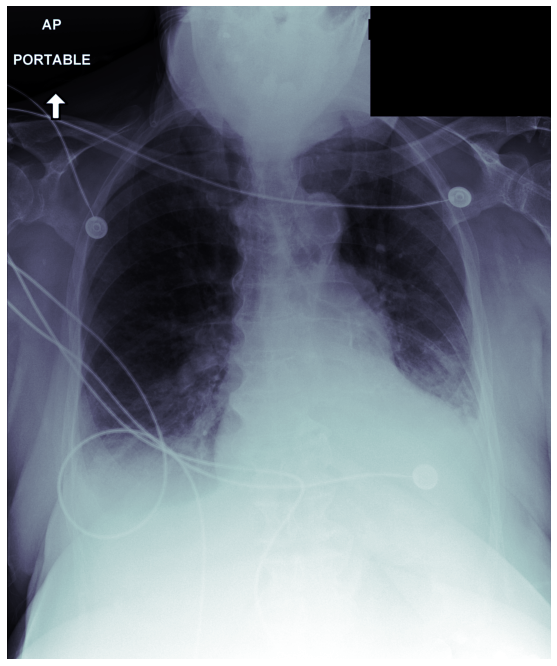

In [ ]:
from PIL import Image
jpg_location = 'gs://mimic-cxr-jpg-2.0.0.physionet.org/'

# first DICOM study
for i, row in cxr_records.iterrows():
  dicom_id = row['dicom_id']
  fn = f'{dicom_id}.jpg'

  # download the image if it hasn't been downloaded yet
  if not os.path.exists(fn):
    path = row['path']
    # the DICOM is located at: {cxr_location}{path}
    !gsutil cp {jpg_location}{path.replace('.dcm', '.jpg')} ./


  # original image
  print(fn)
  image = Image.open(fn)
  fig = plt.figure(figsize=(16,12))
  plt.imshow(image)
  plt.axis('off')
  plt.bone()
  plt.show()

Note that despite using the same colormap, the JPG and DICOM images appear very slightly different. This occurs because histogram equalization was performed when creating the JPG data. You can read more about the JPG subset on [the PhysioNet project page for MIMIC-CXR-JPG](https://physionet.org/content/mimic-cxr-jpg/2.0.0/).

### Combining MIMIC-CXR with MIMIC-IV

One important aspect of MIMIC-CXR and MIMIC-IV are that the dates and times are aligned, meaning the time of an x-ray in the DICOM header for MIMIC-CXR matches the time at which it was performed in MIMIC-IV. Recall that the *poe* table mentioned a few chest x-ray orders - let's look for those rows.

In [ ]:
poe.loc[poe['order_subtype'] == 'General Xray']

,poe_id,poe_seq,subject_id,hadm_id,ordertime,order_type,order_subtype,transaction_type,discontinue_of_poe_id,discontinued_by_poe_id,order_status
119,10012853-320,320,10012853,27882036,2176-11-28 14:40:28,Radiology,General Xray,New,None,None,None
171,10012853-373,373,10012853,27882036,2176-12-01 09:21:16,Radiology,General Xray,New,None,None,None


This says there was an x-ray order at 2176-11-28 14:40:28. We can then look at the metadata in the DICOM header (currently stored in cxr_records) to see if that matches expectation.

In [ ]:
cxr_records[['dicom_id', 'subject_id', 'StudyDate', 'StudyTime']]

,dicom_id,subject_id,StudyDate,StudyTime
0,4736face-6f5f0e13-4b8bac9f-49661d81-a988229c,10012853,21761128,150953.187
1,683930ea-a24d96eb-f0ef3736-3906153d-0ac7d866,10012853,21761128,150953.187


This is telling us that there was an order for an x-ray around 2:40pm, and a chest x-ray study was performed at 3:09pm. Great!

We can visualize where this occurred in the patient's hospital course.

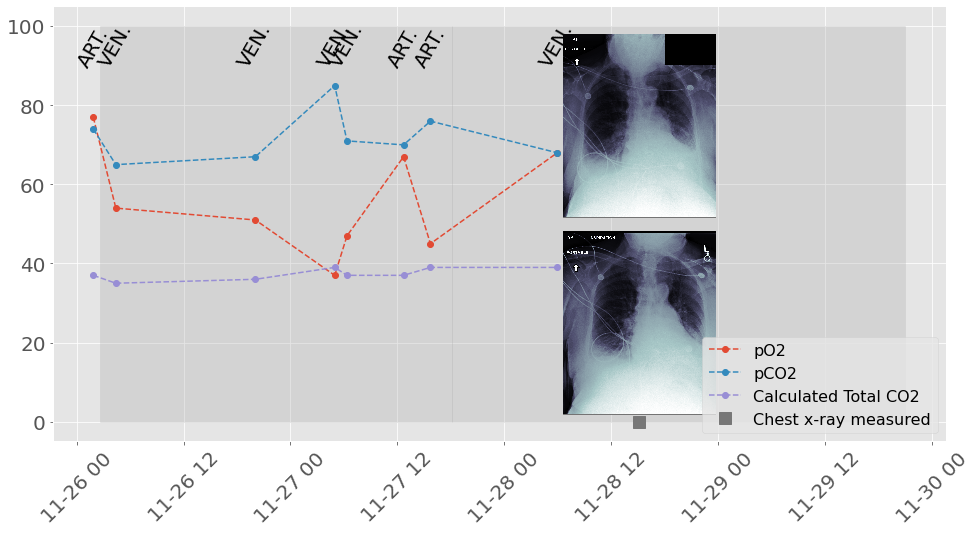

In [ ]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox


plt.figure(figsize=[16, 8])
ax = plt.gca()

# labs
lab_labels = [
  'pO2',
  'pCO2',
  'Calculated Total CO2',
]

for label in lab_labels:
  idx = (lab['label'] == label) & (lab['fluid'] == 'Blood')
  plt.plot(lab.loc[idx, 'charttime'], lab.loc[idx, 'valuenum'], 'o--',  label=f'{label}')

# add specimen type
for i, row in lab.loc[lab['label'] == 'Specimen Type'].iterrows():
  plt.text(row['charttime'], 90, row['value'], rotation=60, ha='center')


# add in the x-rays
for i, row in cxr_records.iterrows():
  dicom_id = row['dicom_id']
  fn = f'{dicom_id}.jpg'

  # get the date/time
  studytime = pd.to_datetime('T'.join([row['StudyDate'], row['StudyTime']]))

  # load in the JPG
  image = Image.open(fn)

  # place it on the axis in an annotation box
  imagebox = OffsetImage(image, zoom=0.06)
  ab = AnnotationBbox(imagebox, (studytime, 25 + i*50), pad=0)
  ax.add_artist(ab)

  if i == 0:
    plt.plot(studytime, 0, 's', markersize=12, label='Chest x-ray measured')

# shade in their ICU stay
for i, row in tr.iterrows():
  if row['careunit'] is None:
    continue
  if 'ICU' in row['careunit']:
    plt.fill_between([row['intime'], row['outtime']], [0, 0], [100, 100], color='#ababab', alpha=0.3)

plt.legend(fontsize=16, loc='lower right')
plt.xticks(rotation=45)
plt.show()

So it appears that this was an x-ray done while the patient was in hospital, but *after* their ICU stay, probably just to check everything was going OK.